# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [173]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### 데이터 읽어오기


In [174]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
# train_data

In [178]:
# 기본 데이터 정보 확인
print("[기본 데이터 정보 확인]")
train_data.info(verbose=True, show_counts=True)
print("\n")

[기본 데이터 정보 확인]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 464 columns):
 #    Column                                                      Non-Null Count  Dtype  
---   ------                                                      --------------  -----  
 0    Wip Line_Dam                                                40506 non-null  object 
 1    Process Desc._Dam                                           40506 non-null  object 
 2    Equipment_Dam                                               40506 non-null  object 
 3    Model.Suffix_Dam                                            40506 non-null  object 
 4    Workorder_Dam                                               40506 non-null  object 
 5    Insp. Seq No._Dam                                           40506 non-null  int64  
 6    Insp Judge Code_Dam                                         40506 non-null  object 
 7    CURE END POSITION X Collect Result_Dam                     

### 불필요 데이터 제거

모든 행이 NaN인 열 제거

In [179]:
# 모든 행이 NaN인 열 제거
print("[모든 행이 NaN인 열 제거]")
train_cleaned = train_data.dropna(axis=1, how='all')
print(train_cleaned)
print("\n")
# train_cleaned 정보 확인
print("[train_cleaned 정보 확인]")
train_cleaned.info(verbose=True, show_counts=True)
# train_cleaned

[모든 행이 NaN인 열 제거]
      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1

중복 데이터 제거

In [180]:
# 1. 중복 행 제거
# 전체 열을 기준으로 중복 행 개수 출력 (열 기준 : subset=['열'],)
dup = train_cleaned.duplicated(keep='first').sum()
print(f"중복 행 개수: {dup}")

# 중복된 행 없음.
# Wip Line_Dam, Process Desc._Dam, Equipment_Dam가 모두 동일

#성현님 코드 일부 삭제

중복 행 개수: 0


동일한 값을 가지는 열 삭제 및 잘못 유입된 값 제거

In [181]:
# 모든 행이 동일한 값을 가지는 열 찾기
constant_columns = [col for col in train_cleaned.columns
                    if train_cleaned[col].nunique(dropna=False) == 1]

print("모든 행이 동일한 값을 가지는 열:", constant_columns)

train_cleaned = train_cleaned.drop(columns=constant_columns)

모든 행이 동일한 값을 가지는 열: ['Wip Line_Dam', 'Process Desc._Dam', 'Insp. Seq No._Dam', 'Insp Judge Code_Dam', 'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam', 'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave', 'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave', 'Wip Line_Fill1', 'Process Desc._Fill1', 'Insp. Seq No._Fill1', 'Insp Judge Code_Fill1', 'Wip Line_Fill2', 'Process Desc._Fill2', 'Insp. Seq No._Fill2', 'Insp Judge Code_Fill2', 'CURE END POSITION Θ Collect Result_Fill2', 'CURE STANDBY POSITION X Collect Result_Fill2', 'CURE STANDBY POSITION Θ Collect Result_Fill2', 'CURE START POSITION Θ Collect Result_Fill2', 'DISCHARGED SPEED OF RESIN Collect Result_Fill2', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2', 'DI

In [182]:
# 특정 칼럼에서 'OK' 값을 NaN으로 치환하는 함수 정의
def replace_ok_with_nan(column):
    return column.replace('OK', np.nan)

# 칼럼 리스트
columns_to_clean = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# 이상치 치환
for col in columns_to_clean:
    train_cleaned.loc[:, col] = replace_ok_with_nan(train_cleaned[col])

# 결측치 제거한 데이터 저장경로 설정
save_path = os.path.join(ROOT_DIR, "cleaned_train_data.csv")

# 수정된 데이터 저장
train_cleaned.to_csv(save_path, index=False)

데이터 통계량 확인

In [183]:
# train_cleaned 데이터의 통계량 확인
statistics = train_cleaned.describe()

# 통계량을 저장할 경로 설정
stats_save_path = os.path.join(ROOT_DIR, "train_cleaned_statistics.csv")

# 통계량 계산 및 저장
statistics = train_cleaned.describe()
statistics.to_csv(stats_save_path, index=True)

# 통계량 출력
print(statistics)

       CURE END POSITION X Collect Result_Dam  \
count                            40506.000000   
mean                               530.370809   
std                                369.283055   
min                                240.000000   
25%                                240.000000   
50%                                240.000000   
75%                               1000.000000   
max                               1000.000000   

       CURE END POSITION Z Collect Result_Dam  \
count                            40506.000000   
mean                                 6.320669   
std                                  4.858988   
min                                  2.500000   
25%                                  2.500000   
50%                                  2.500000   
75%                                 12.500000   
max                                 12.500000   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
count                            405

### 결측치 처리

결측치 연구

In [185]:
# 각 열의 결측치 개수 출력
nan_counts = train_cleaned.isna().sum()

# 결측치가 있는 열만 출력
nan_counts_with_nan = nan_counts[nan_counts > 0]

# 각 열과 결측치 개수 출력
for column, count in nan_counts_with_nan.items():
    print(f"{column}: {count}개의 결측치")
    print(f"{column}: {train_cleaned[column].dtype}")
    print(train_cleaned[column].value_counts()) # NaN이 아닌 데이터 개수도 함께 출력

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam: 24059개의 결측치
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam: object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
549      7271
162.4    3580
550      2398
550.3    1909
549.5    1263
548.5      26
Name: count, dtype: int64
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam: 29213개의 결측치
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam: object
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
OK    11293
Name: count, dtype: int64
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave: 29213개의 결측치
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave: object
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
OK    11293
Name: count, dtype: int64
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave: 29213개의 결측치
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave: object
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
OK    11293
Name: count, dtype: int64
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Resu

결측치 대체

In [186]:
# 결측치가 있는 열에 대해 평균값으로 대체
# for column in nan_counts_with_nan.index:
#     train_cleaned[column].fillna(train_cleaned[column].mean(), inplace=True)
    


### 이상치 처리

이상치 연구

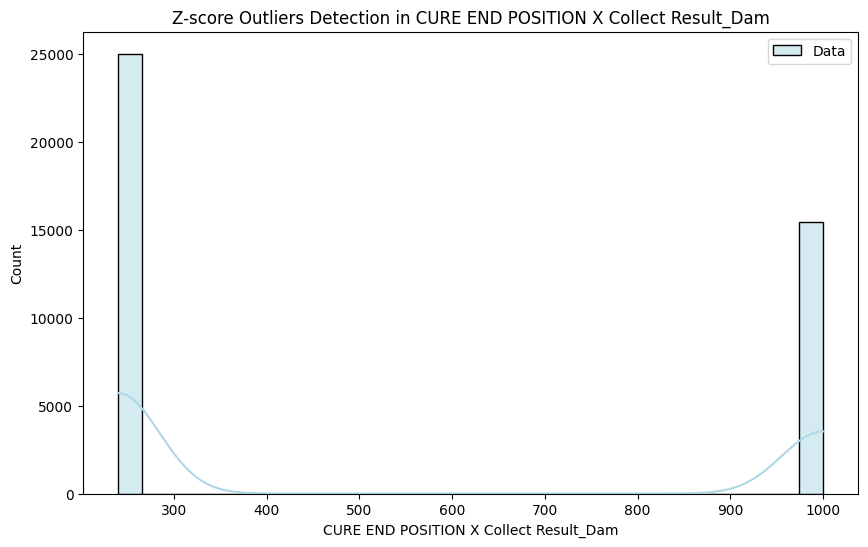

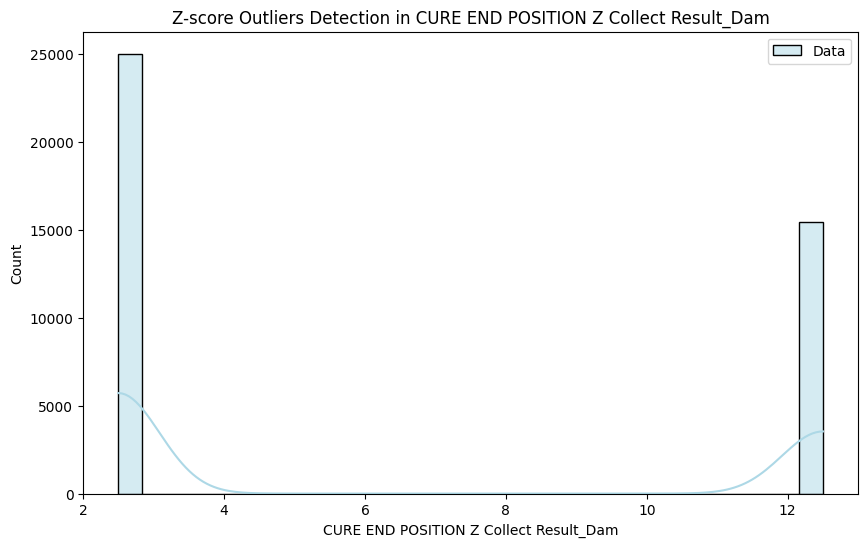

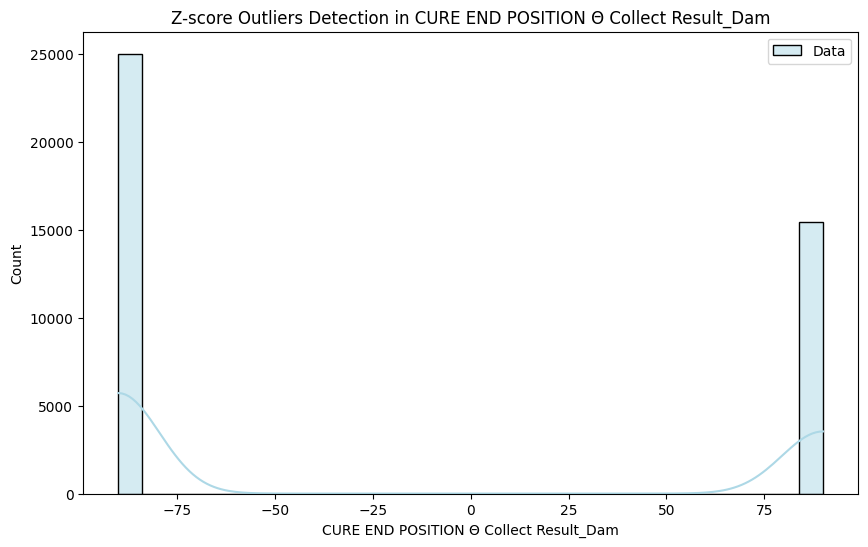

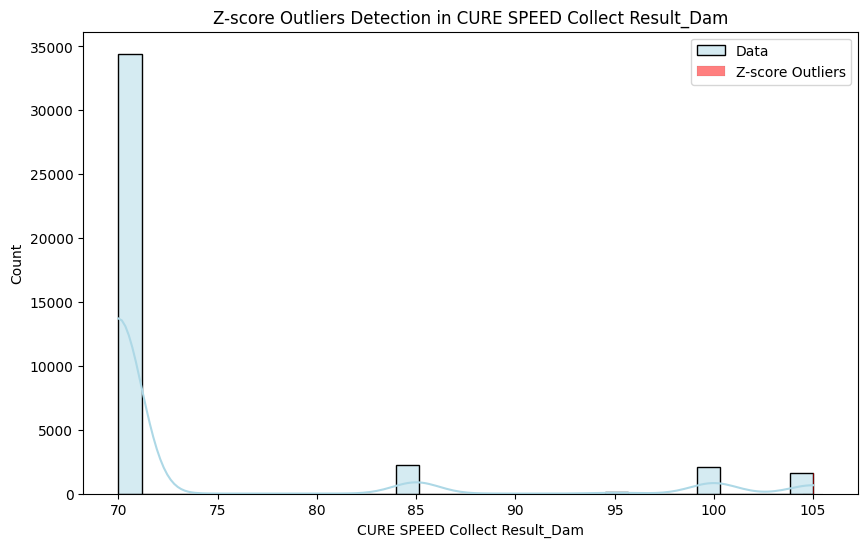

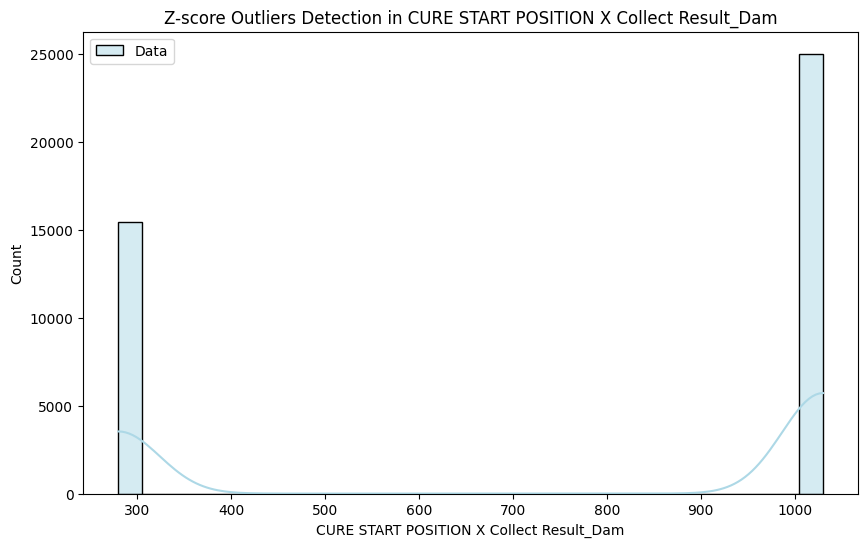

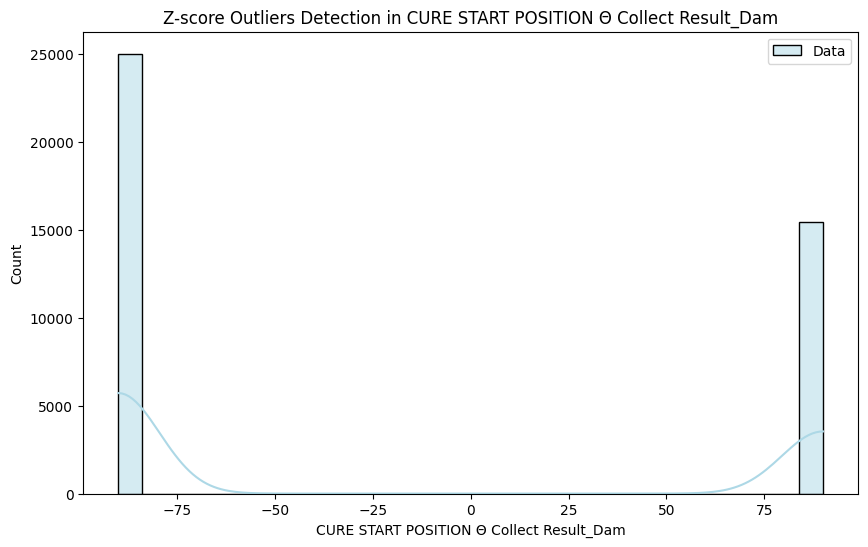

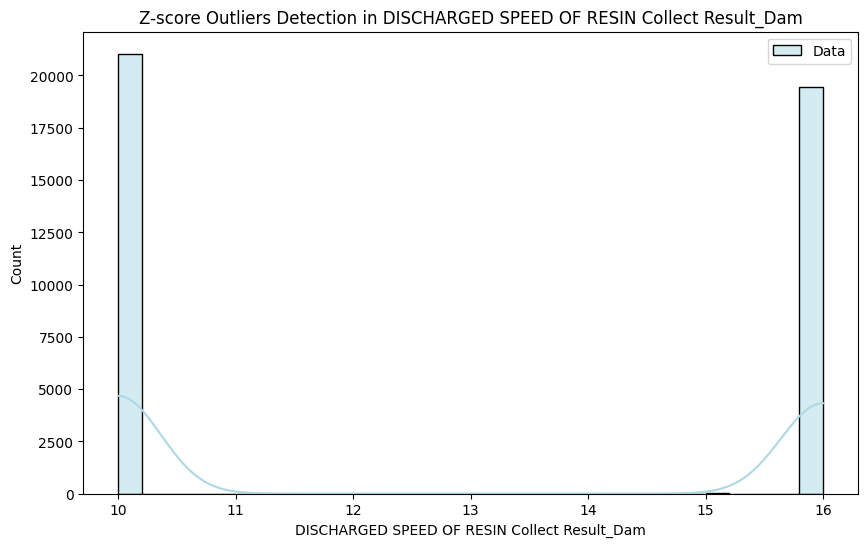

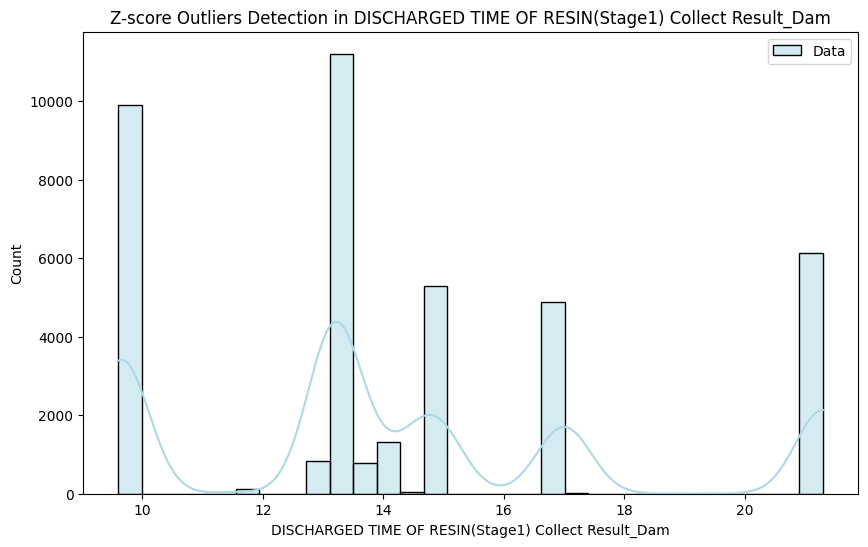

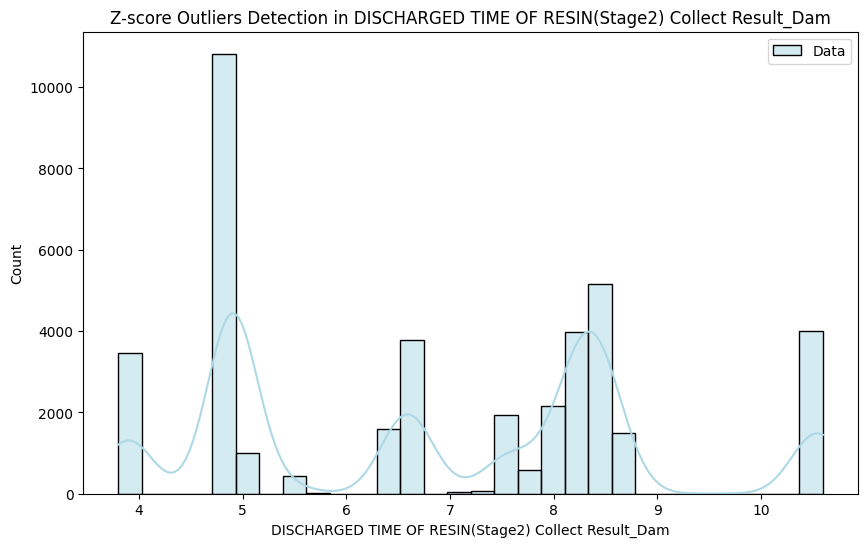

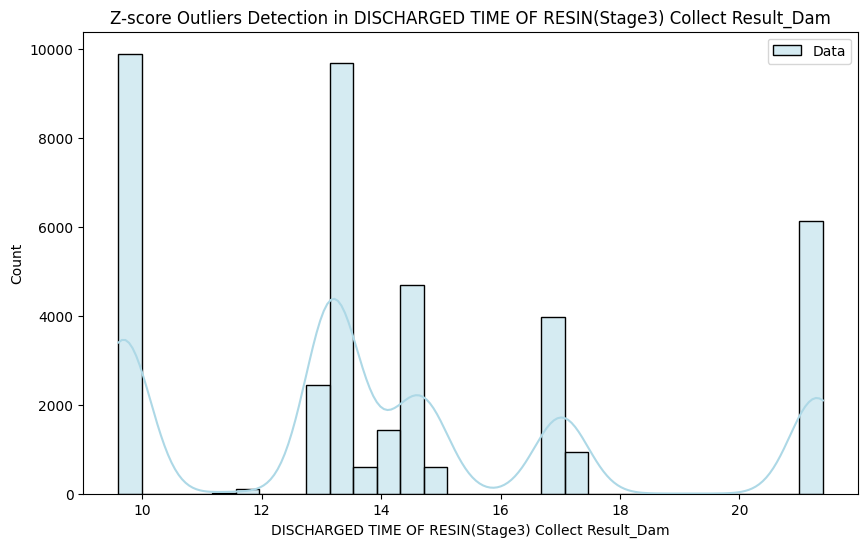

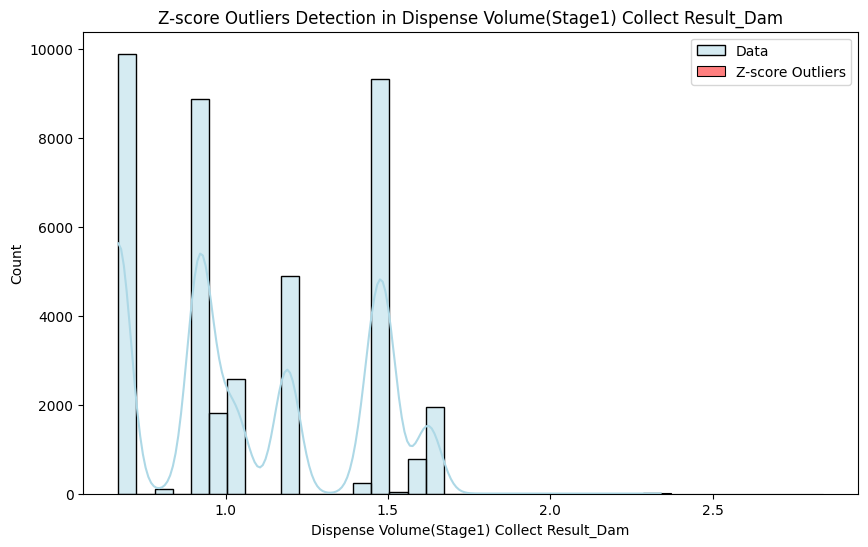

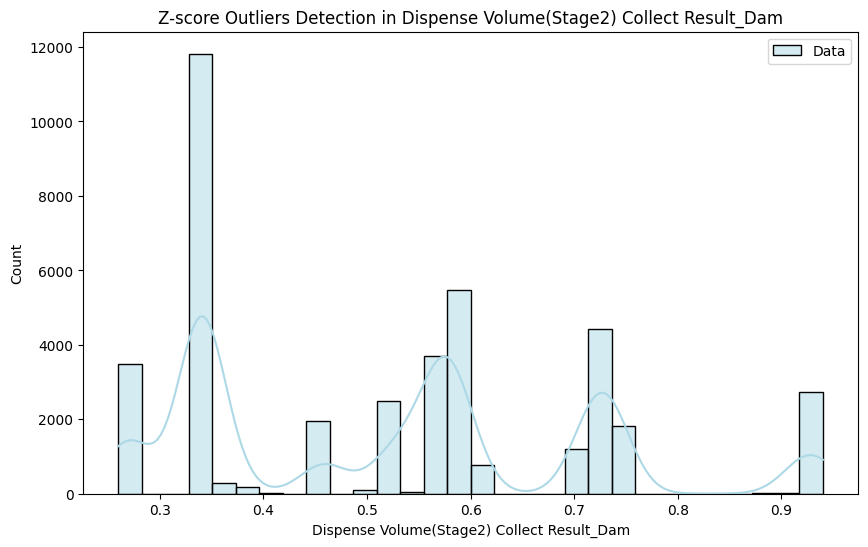

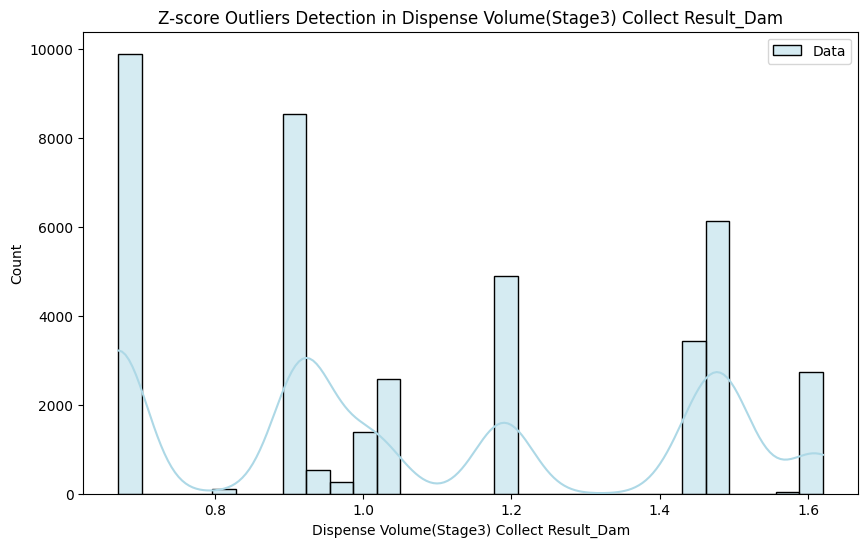

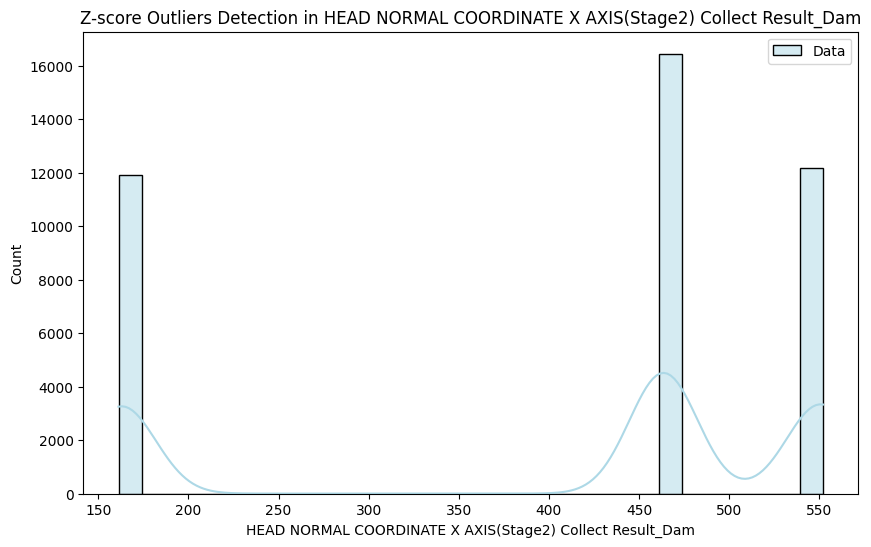

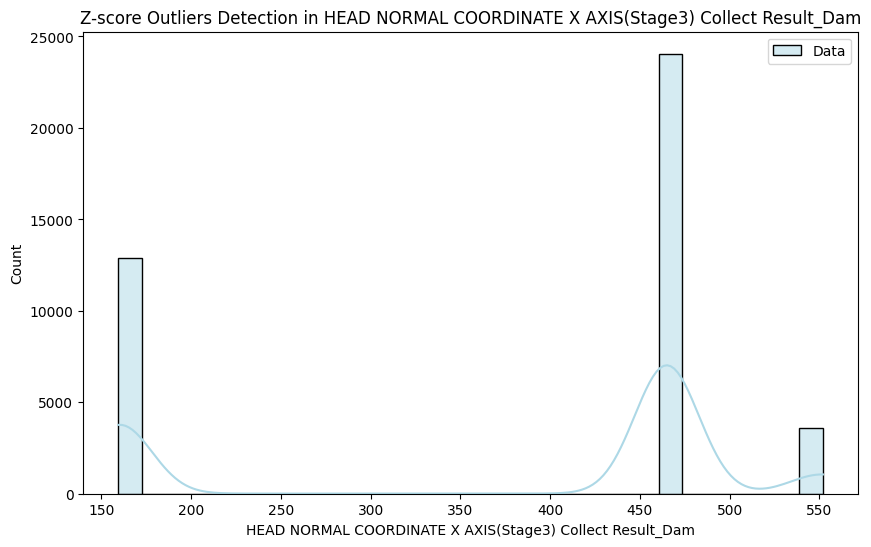

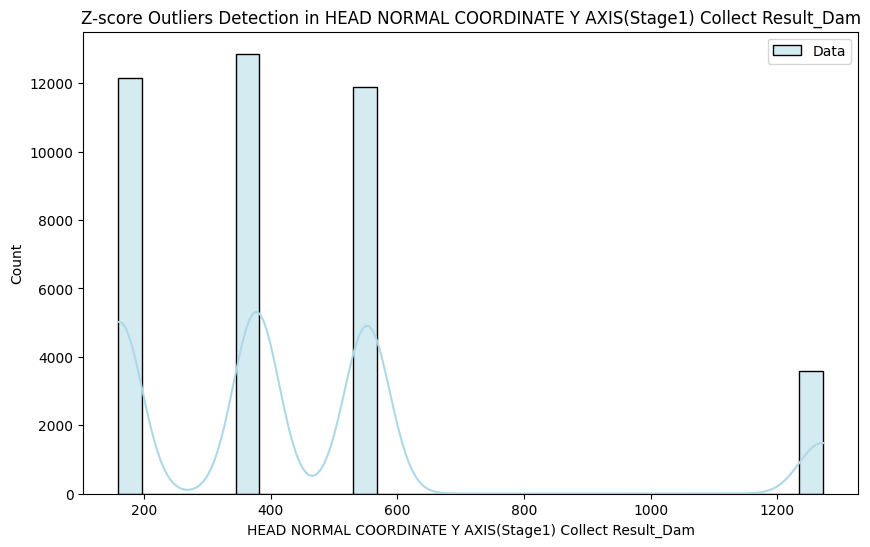

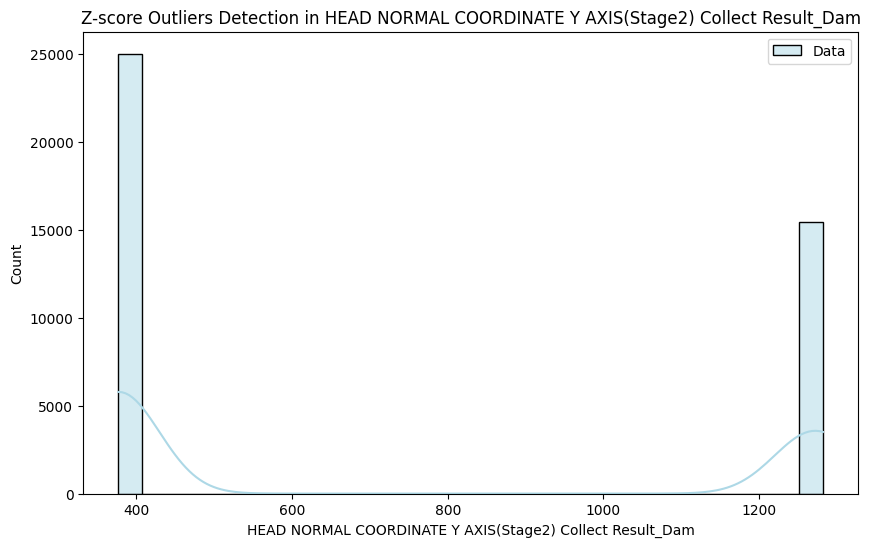

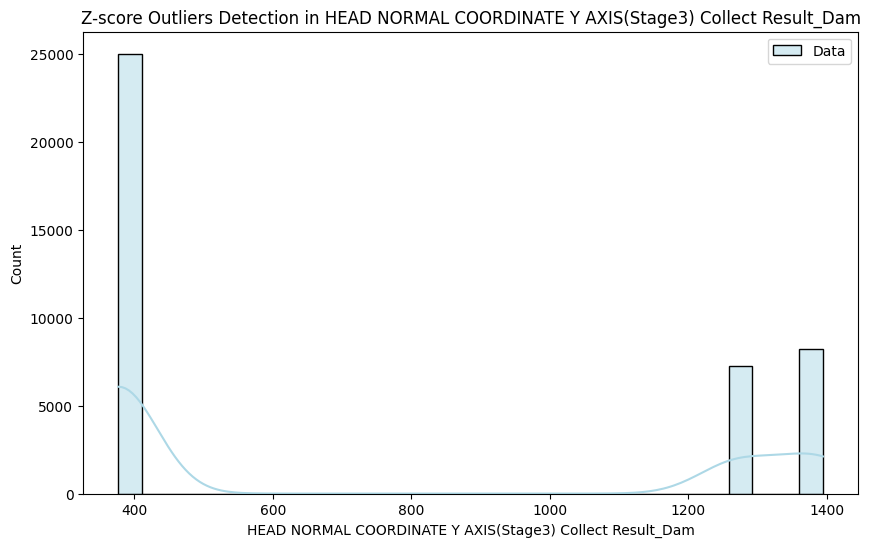

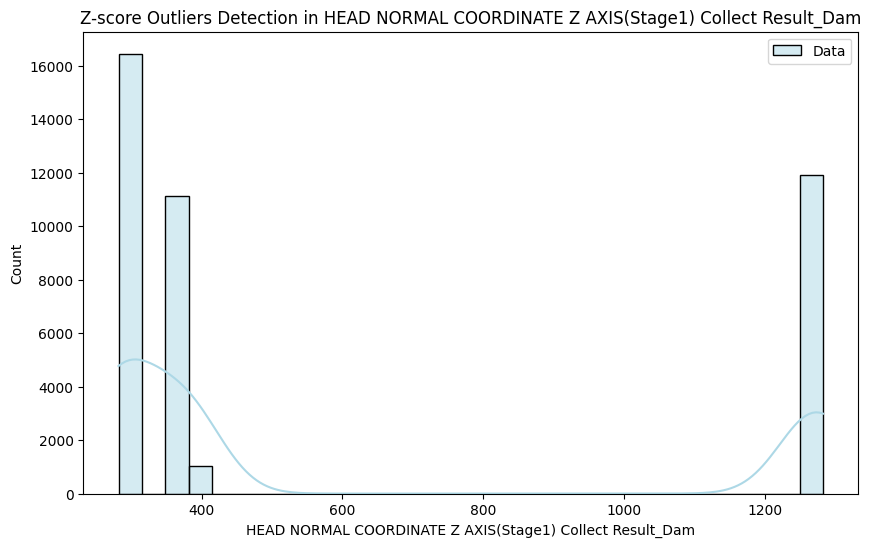

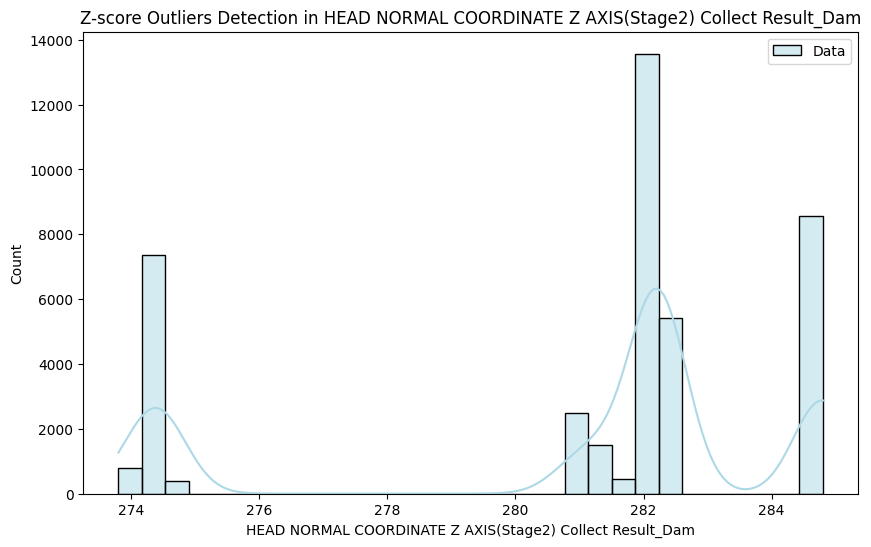

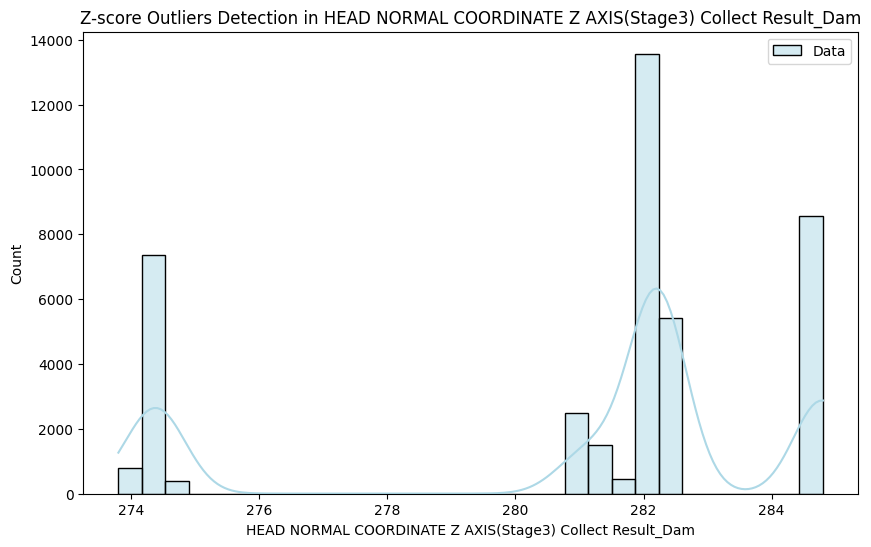

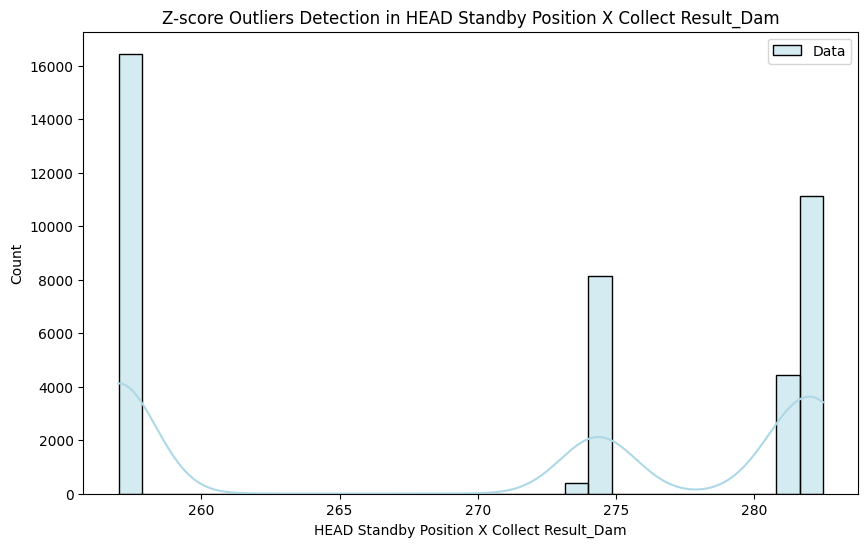

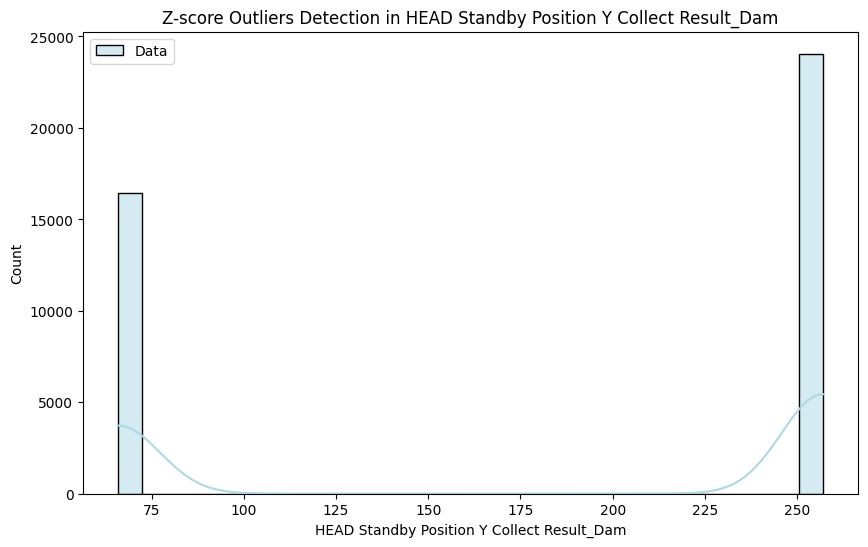

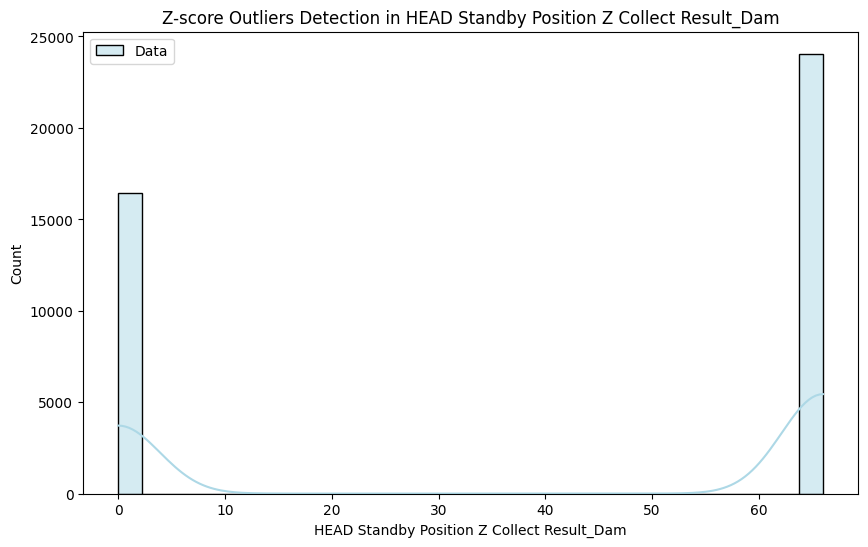

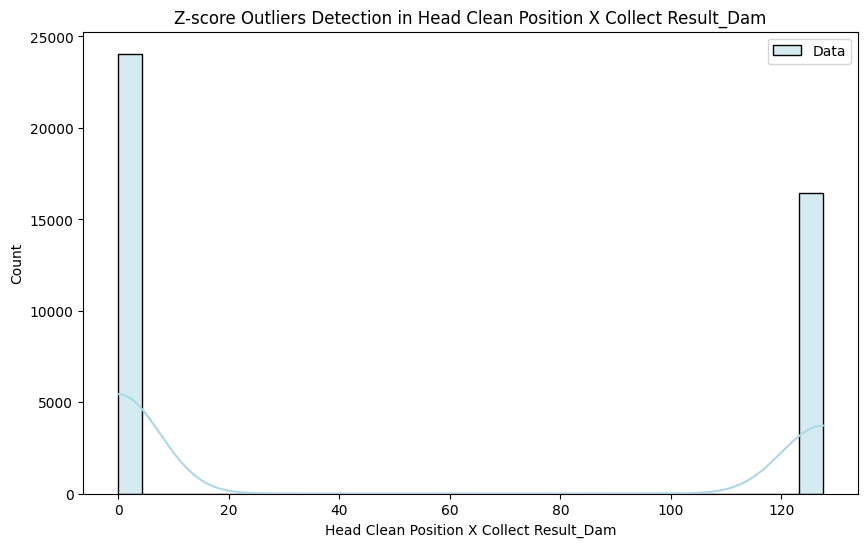

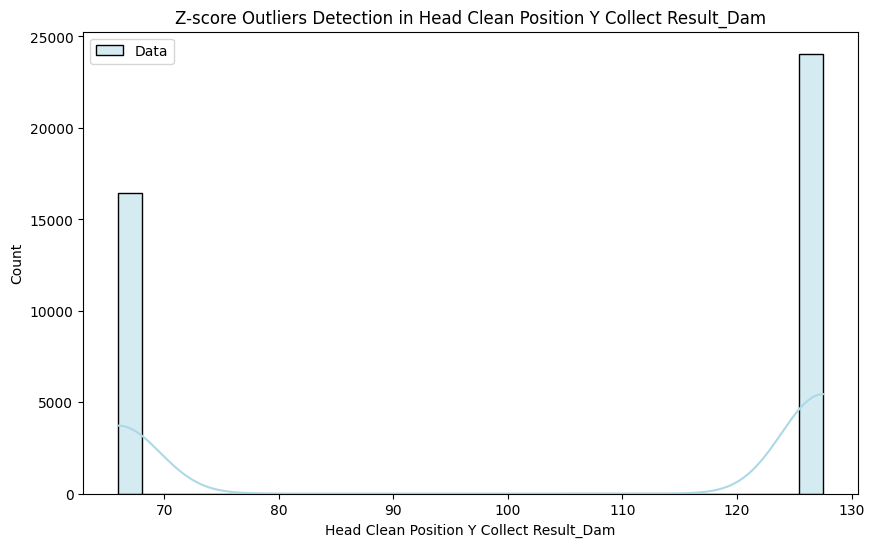

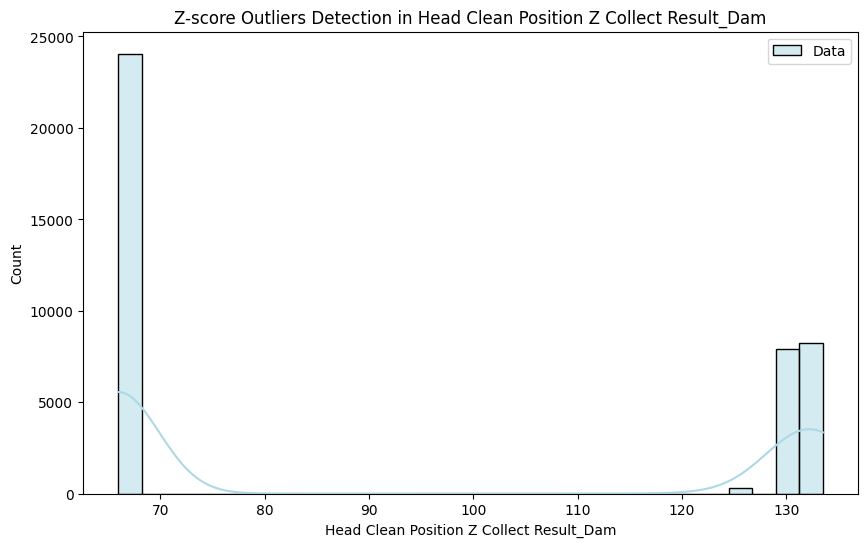

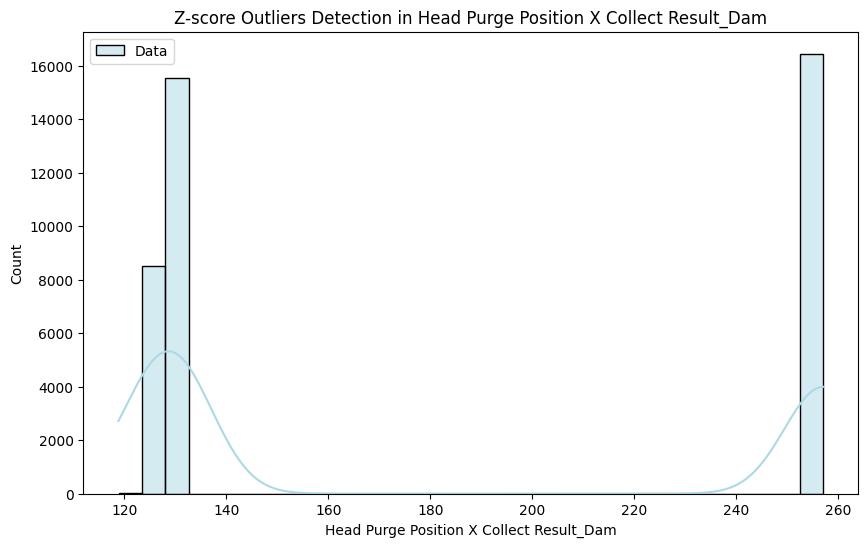

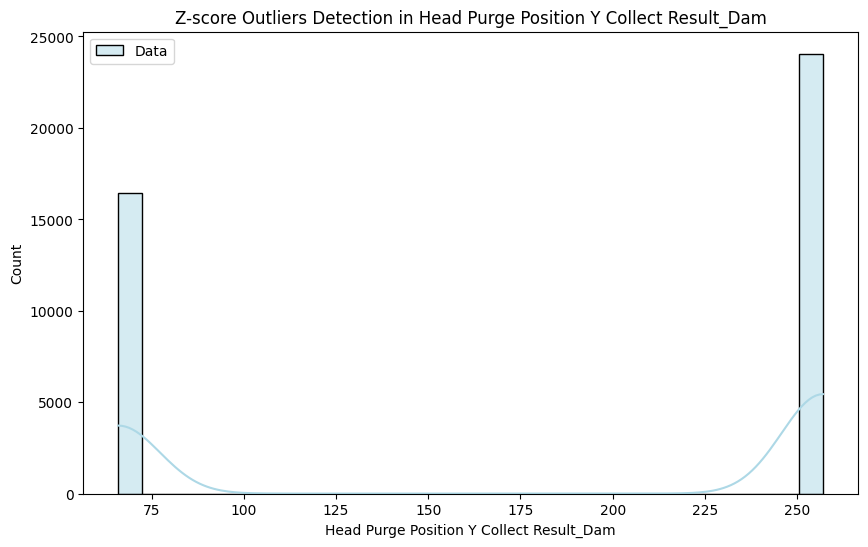

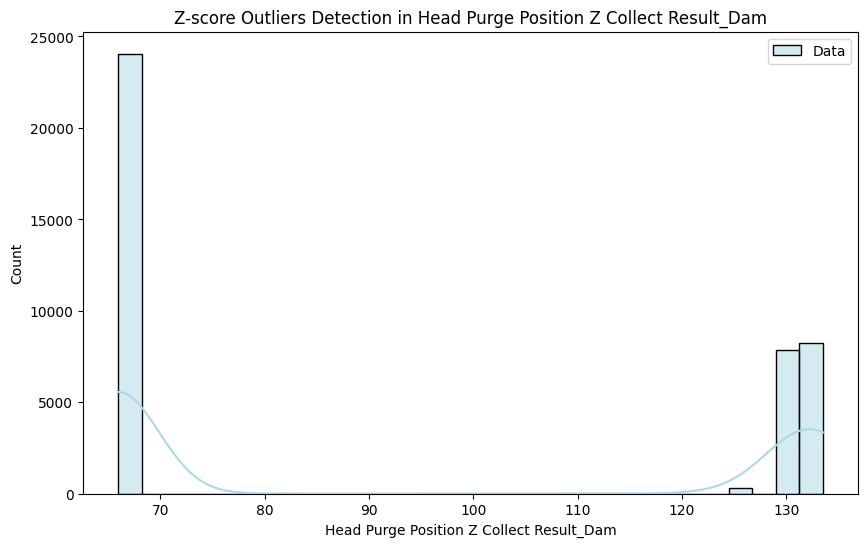

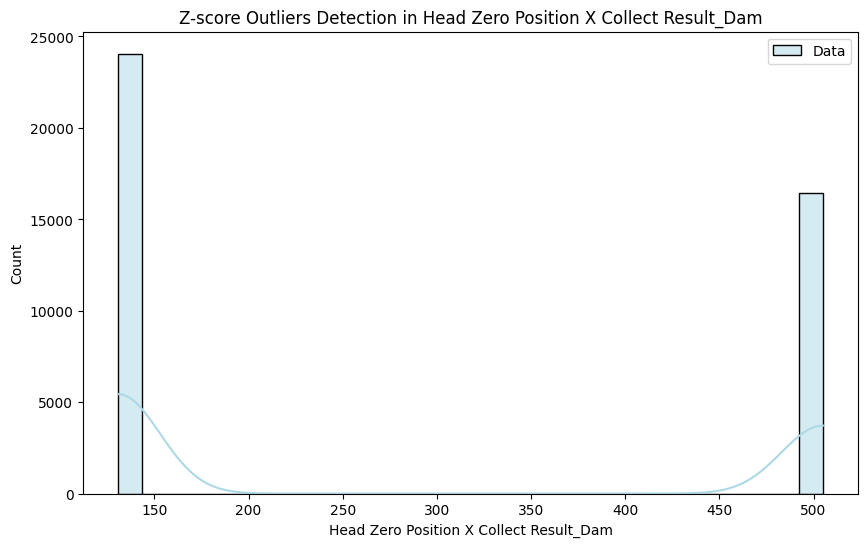

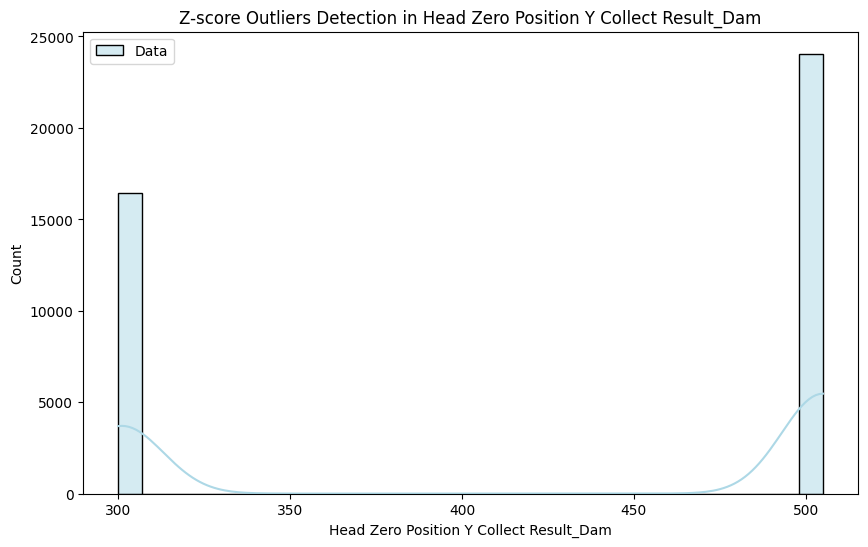

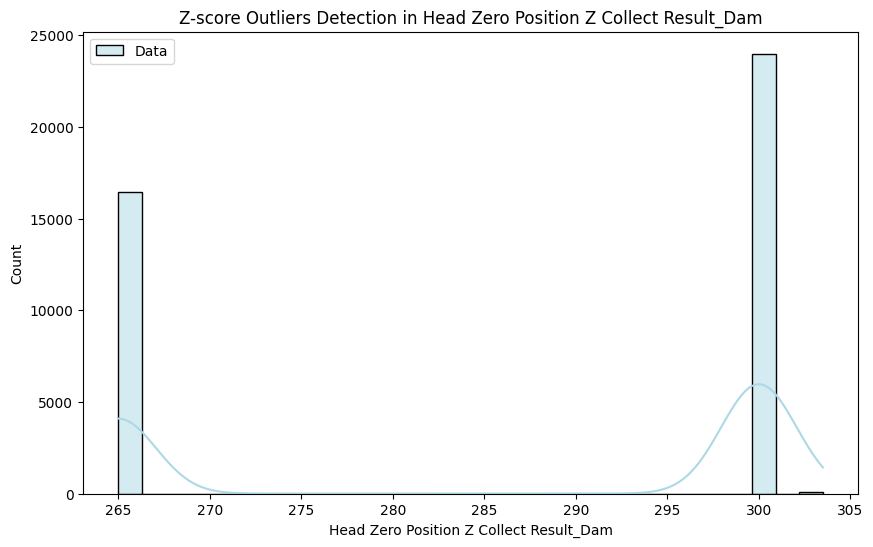

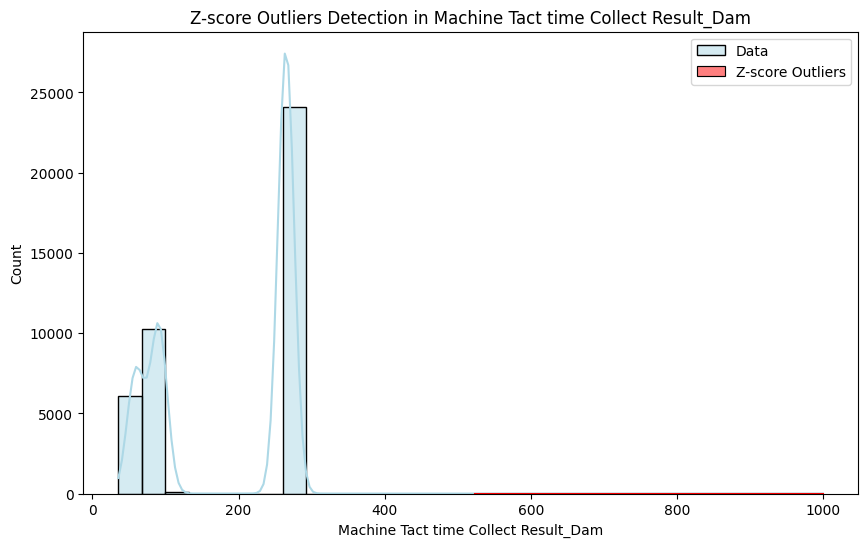

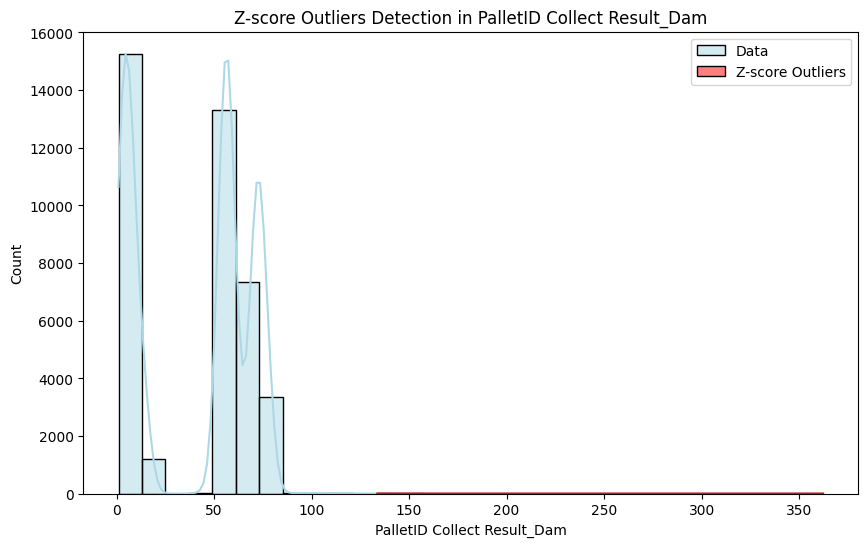

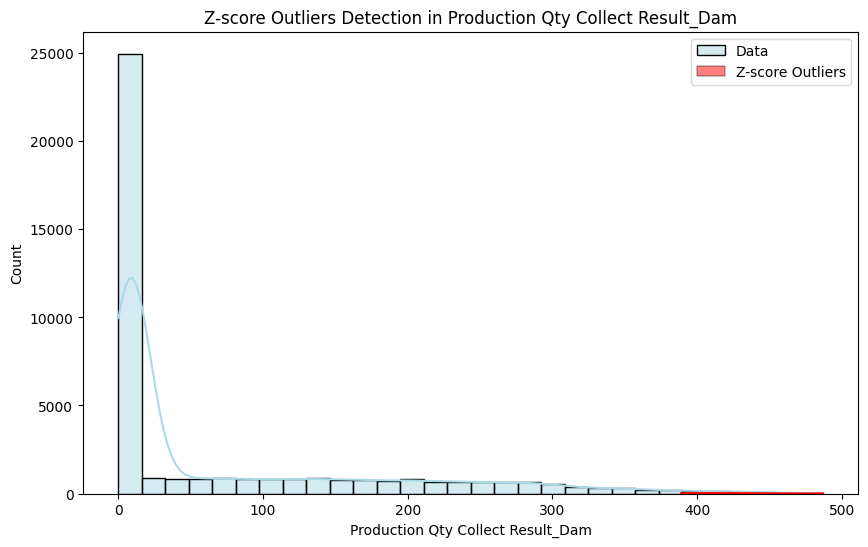

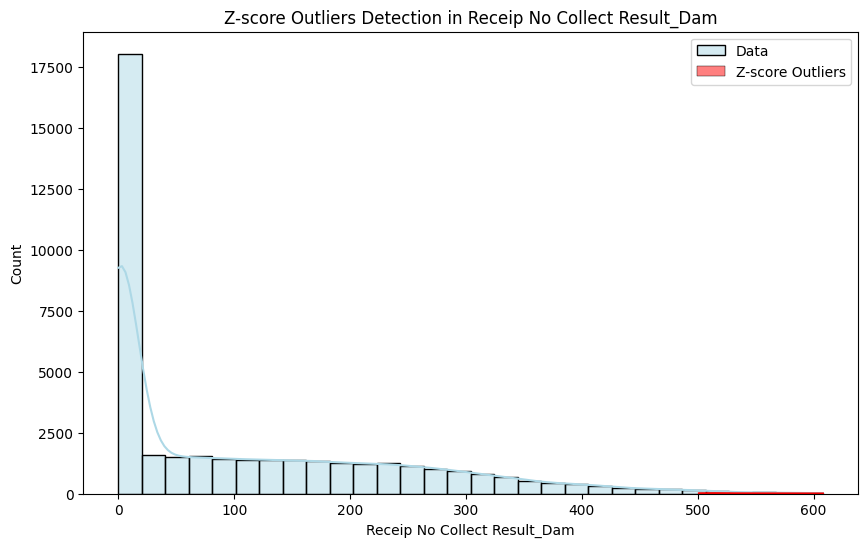

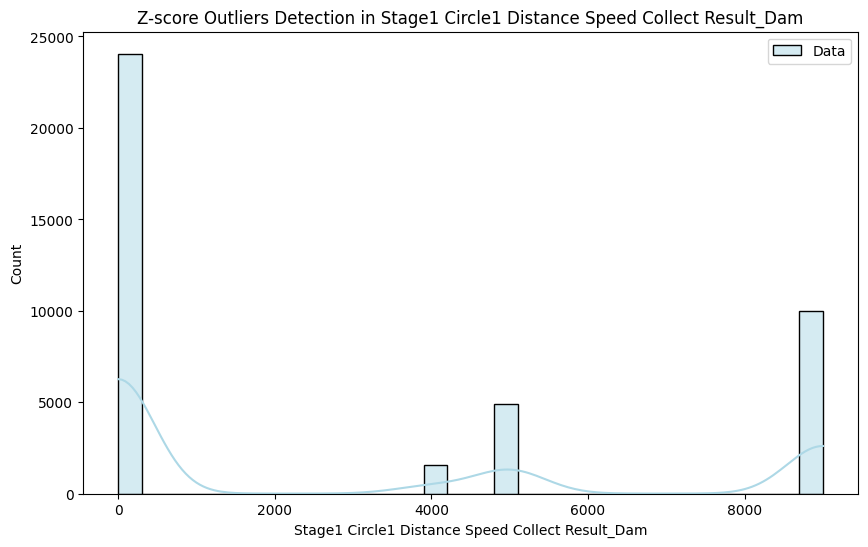

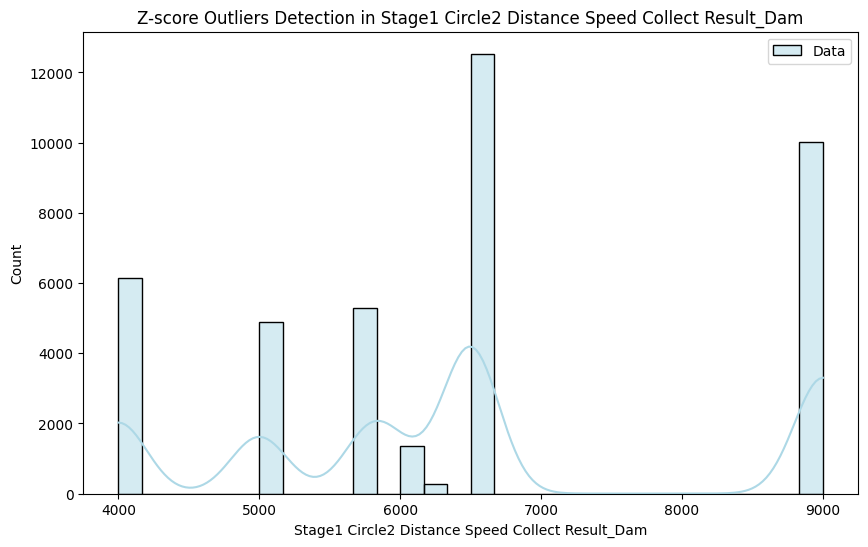

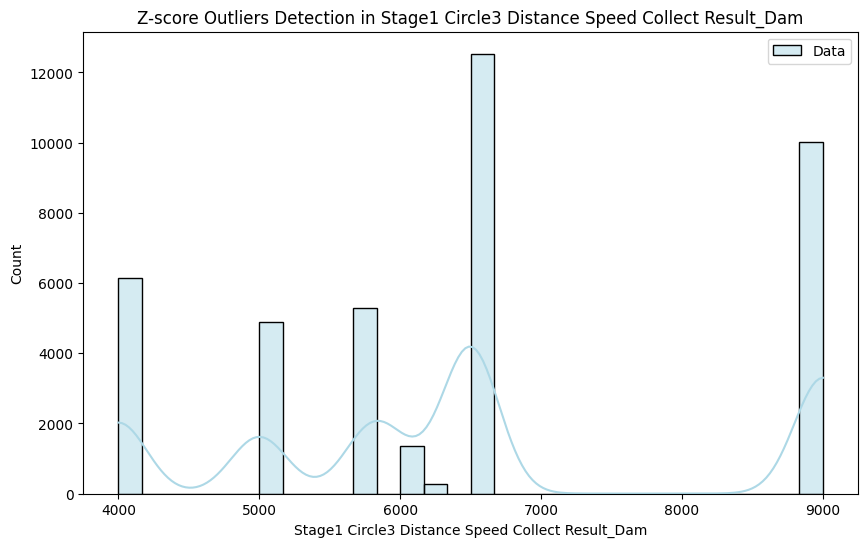

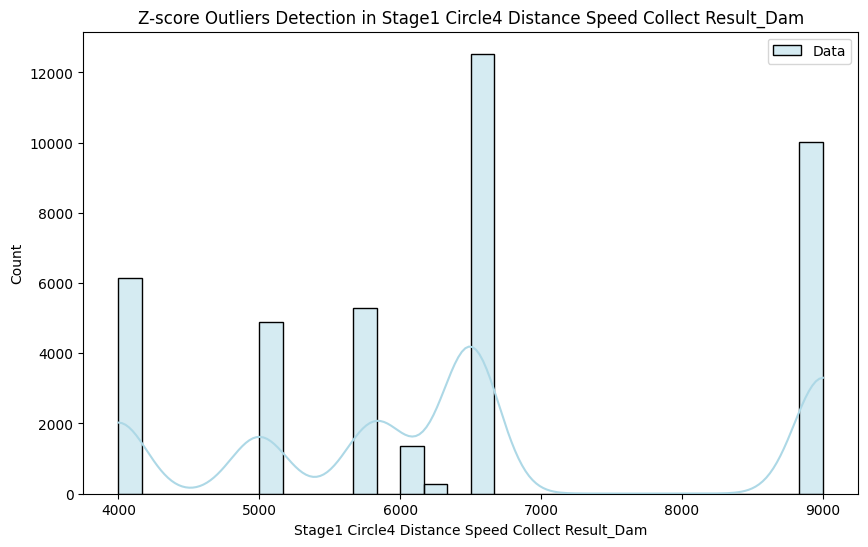

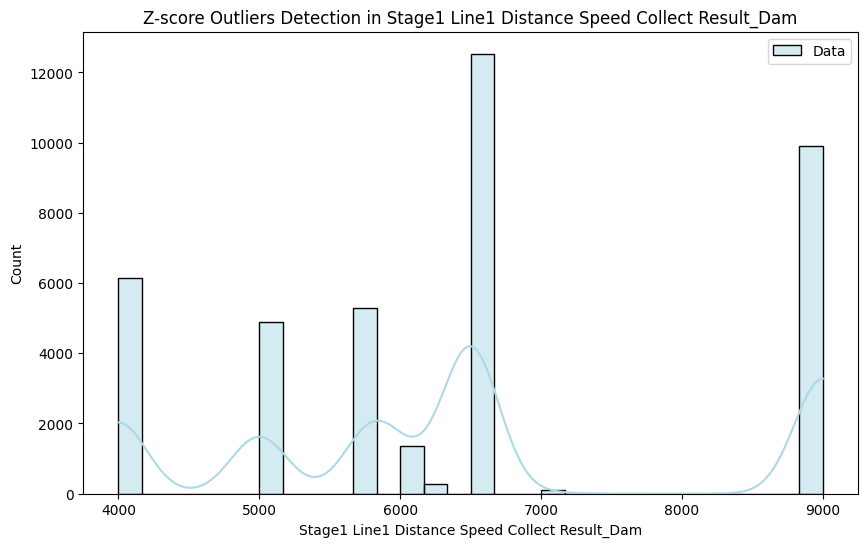

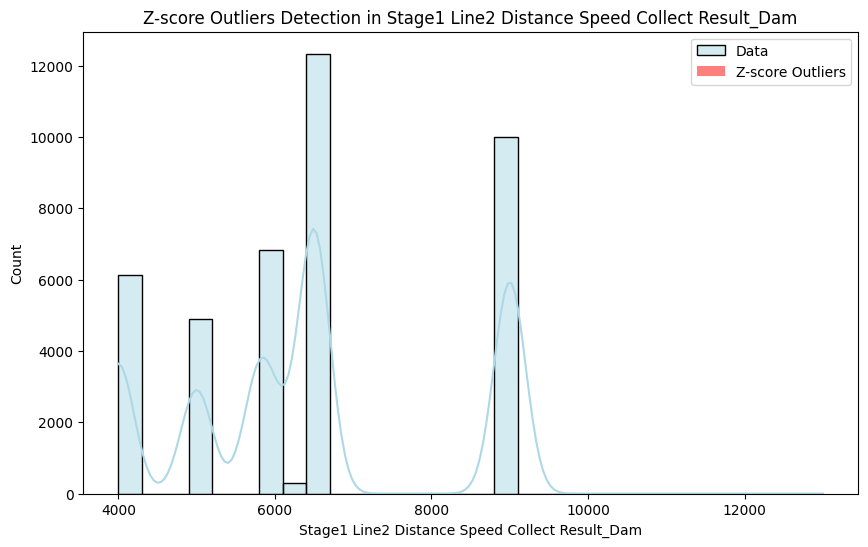

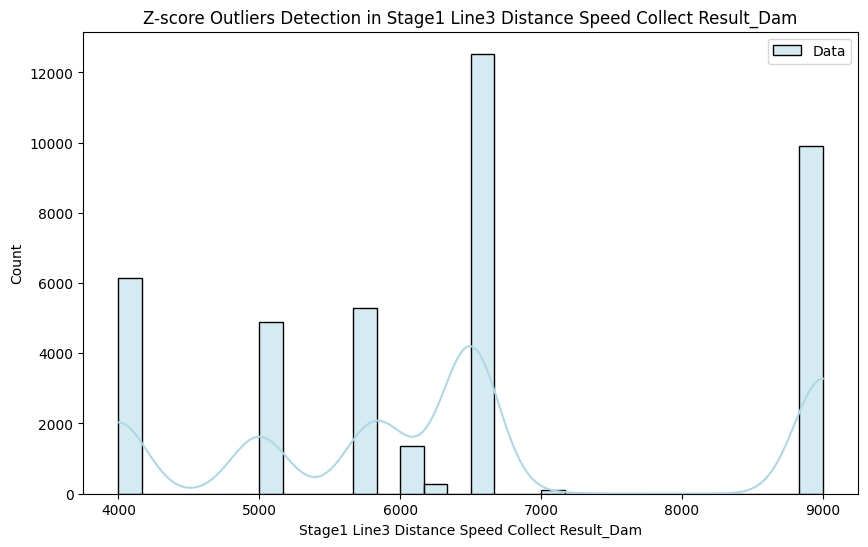

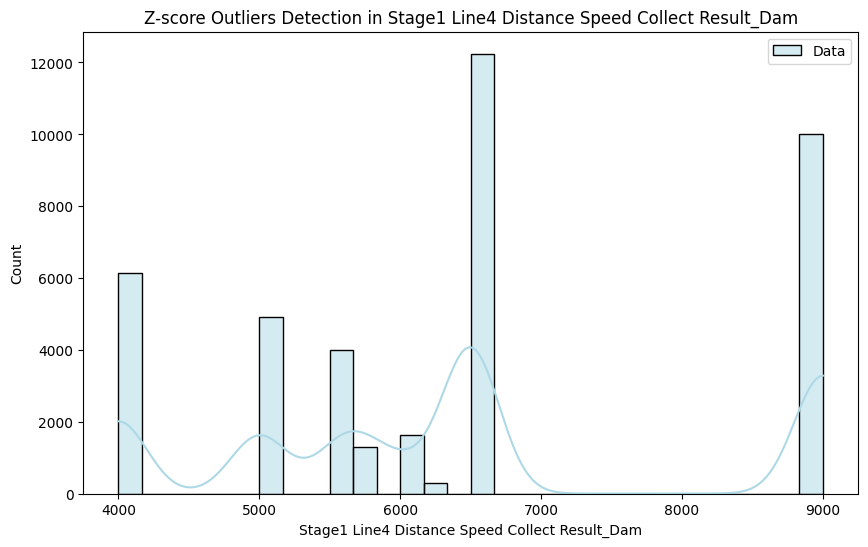

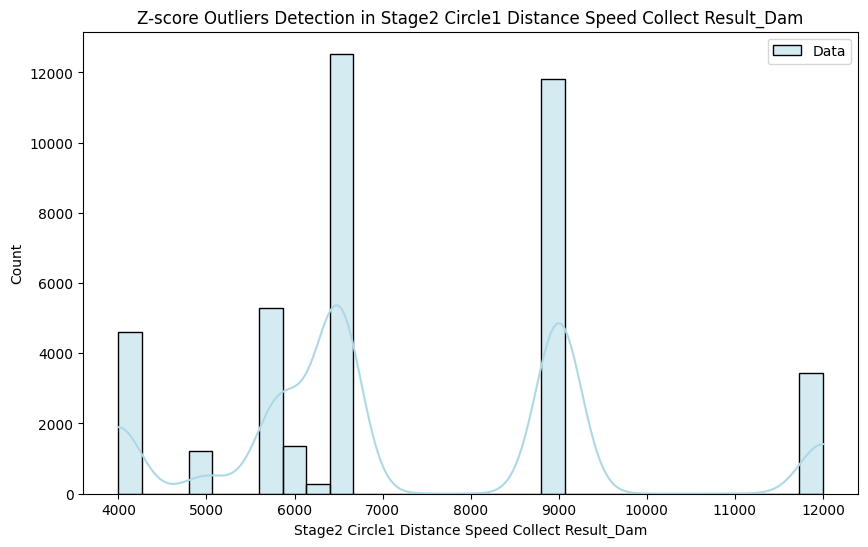

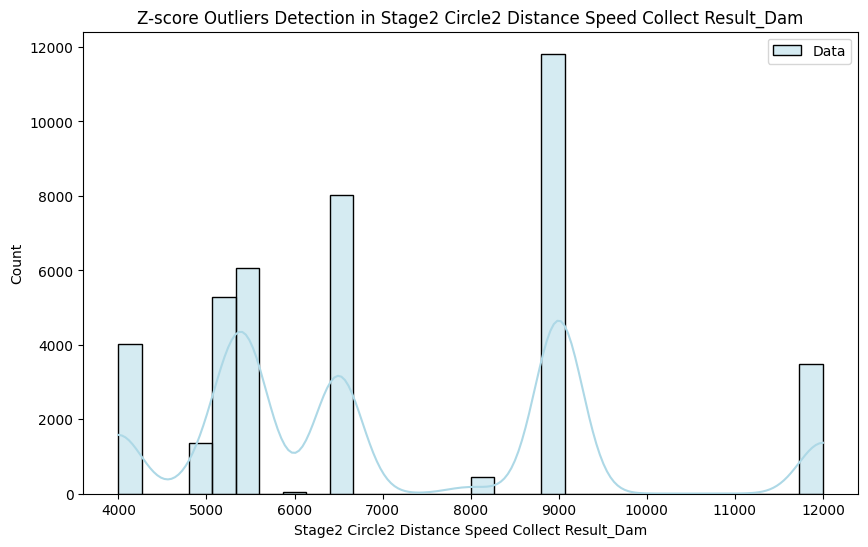

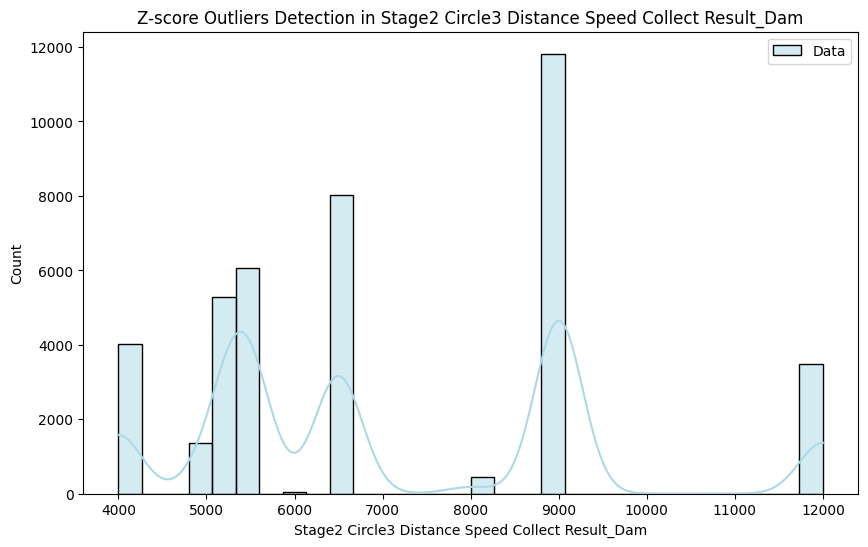

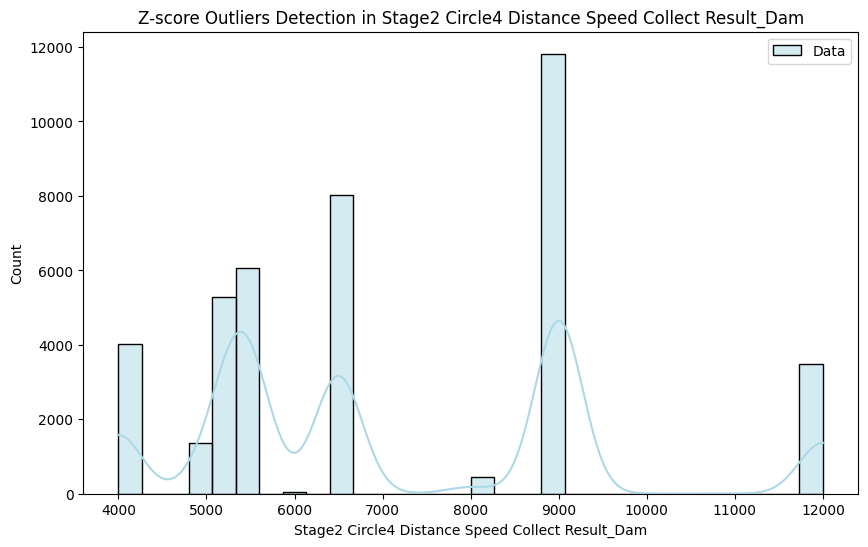

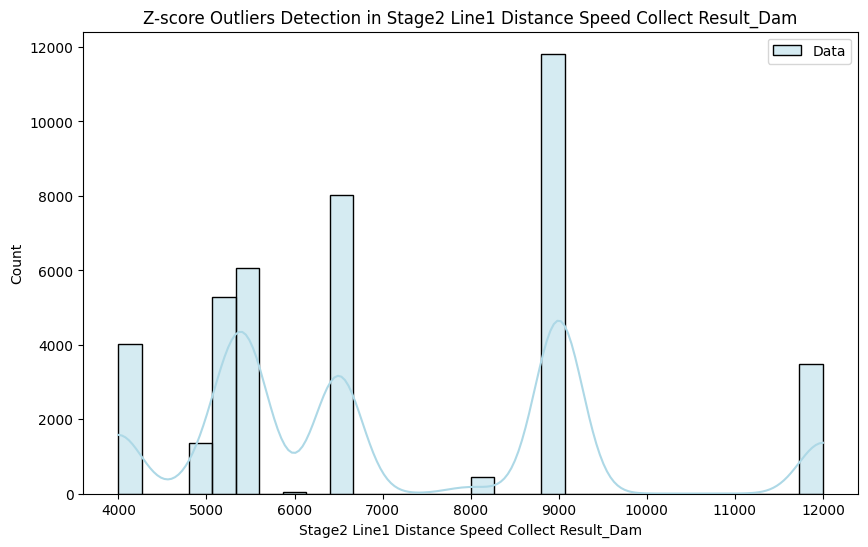

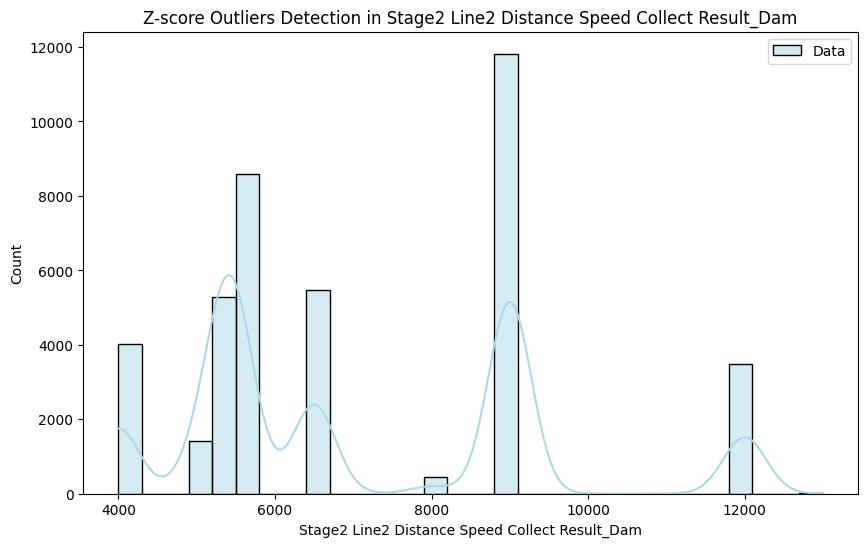

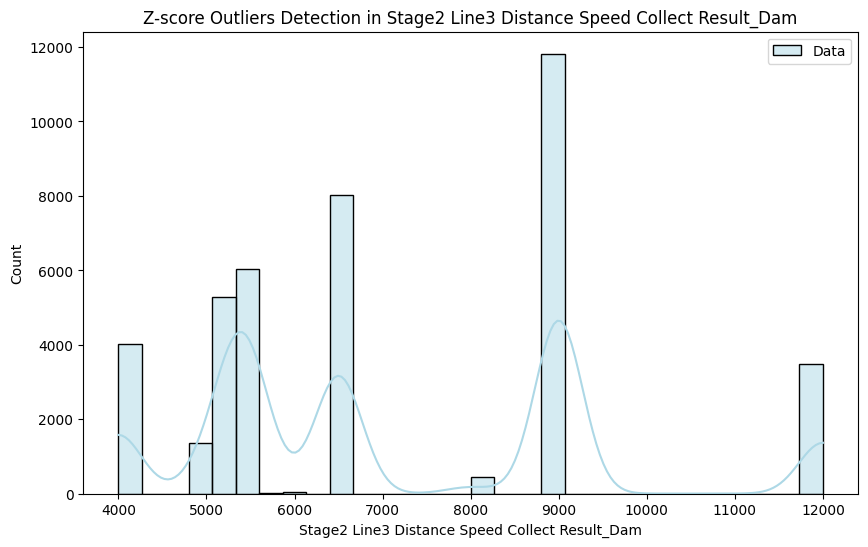

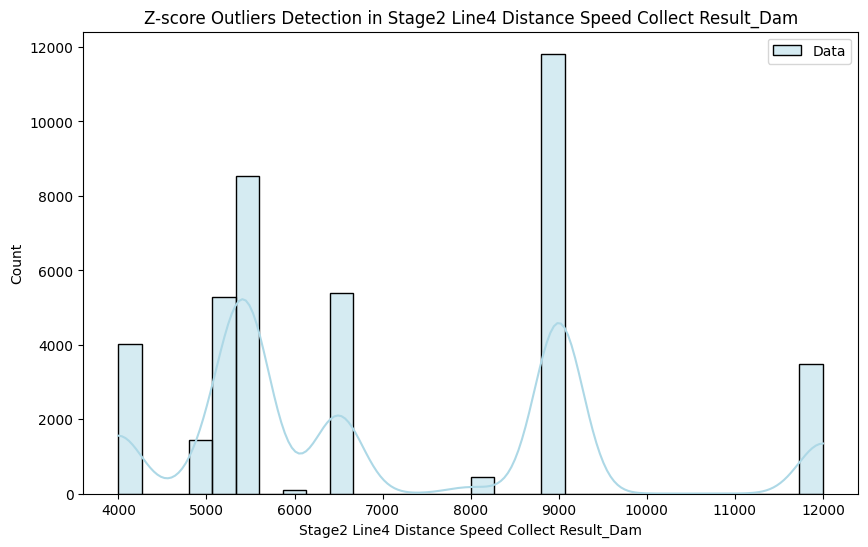

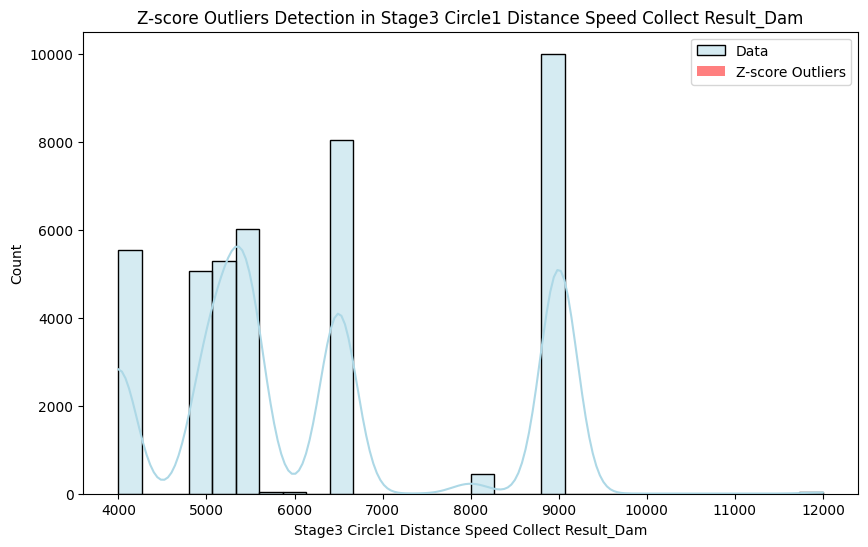

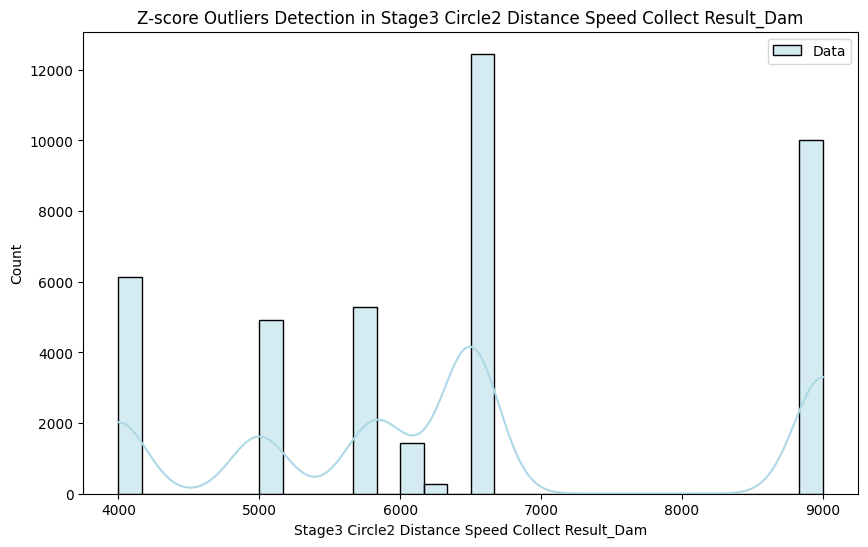

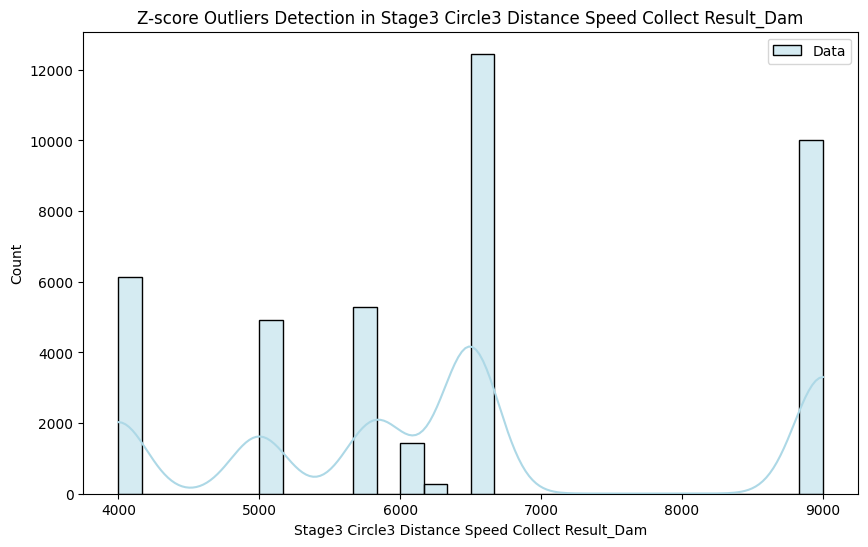

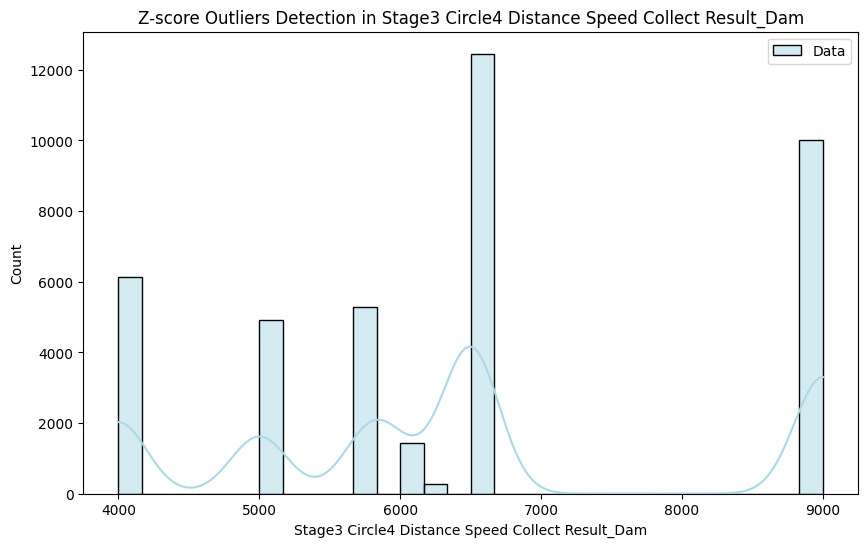

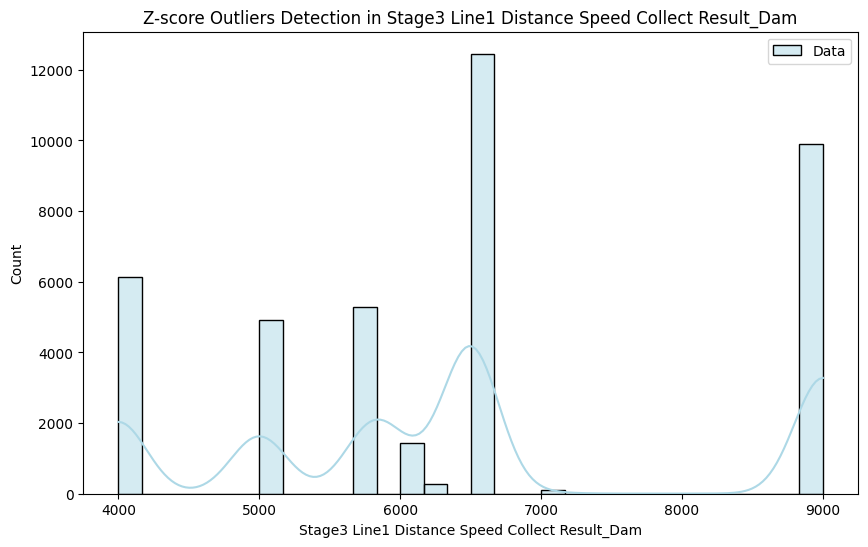

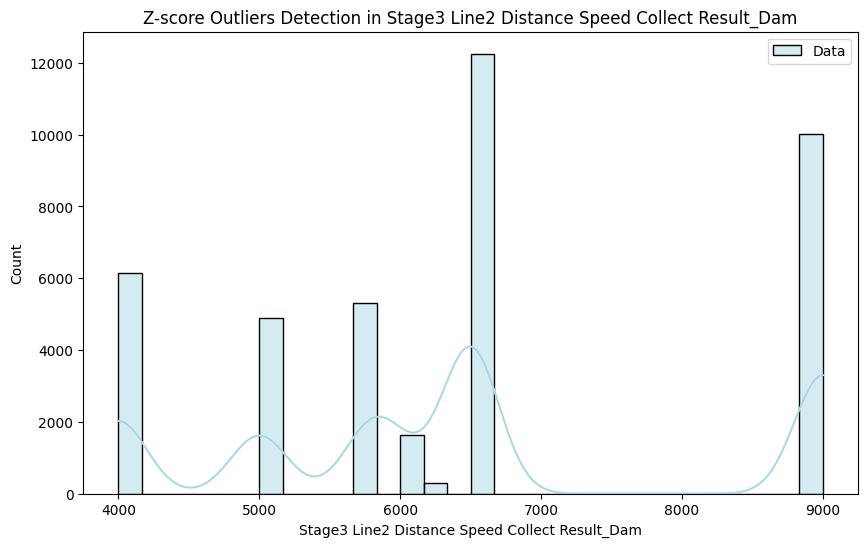

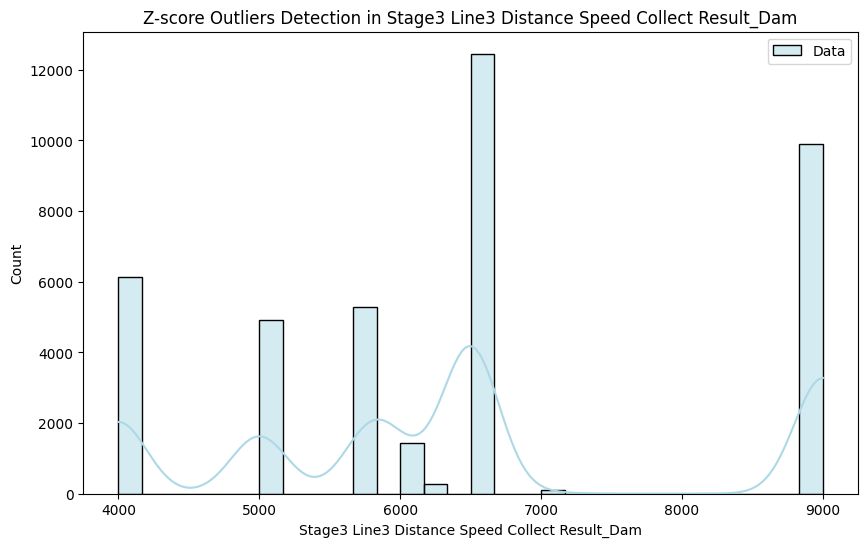

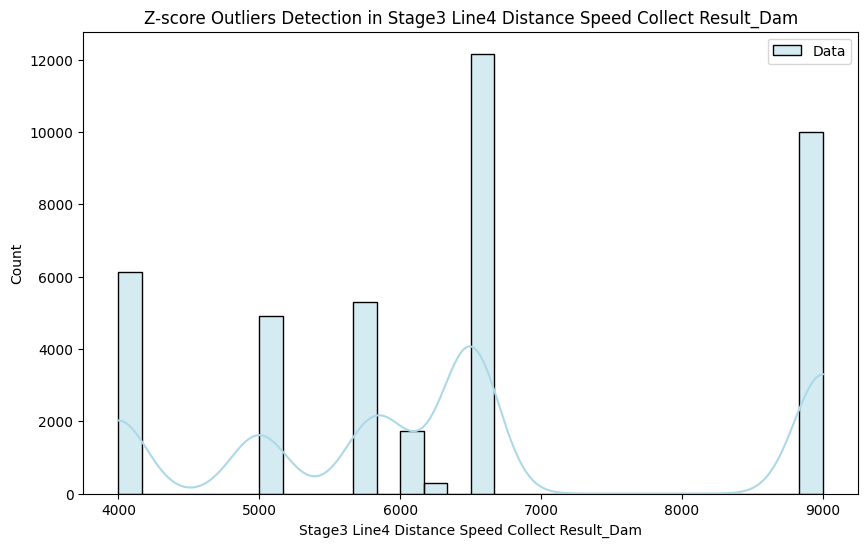

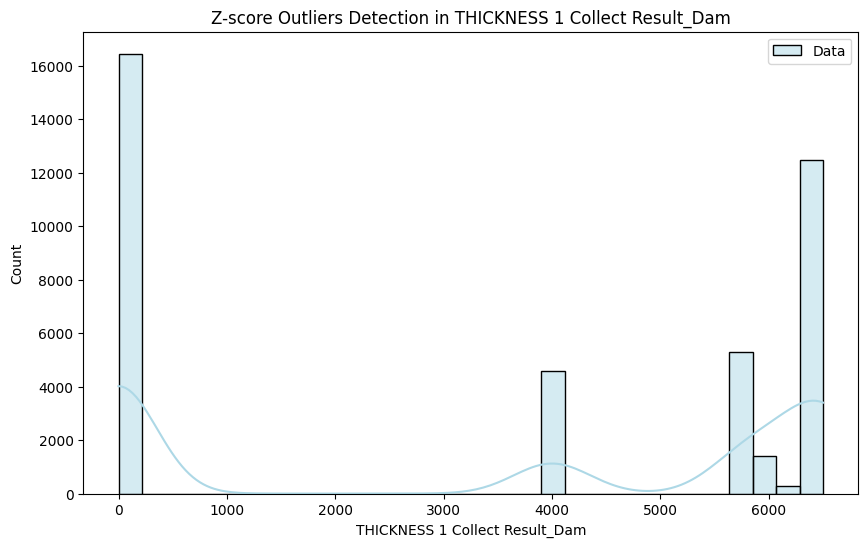

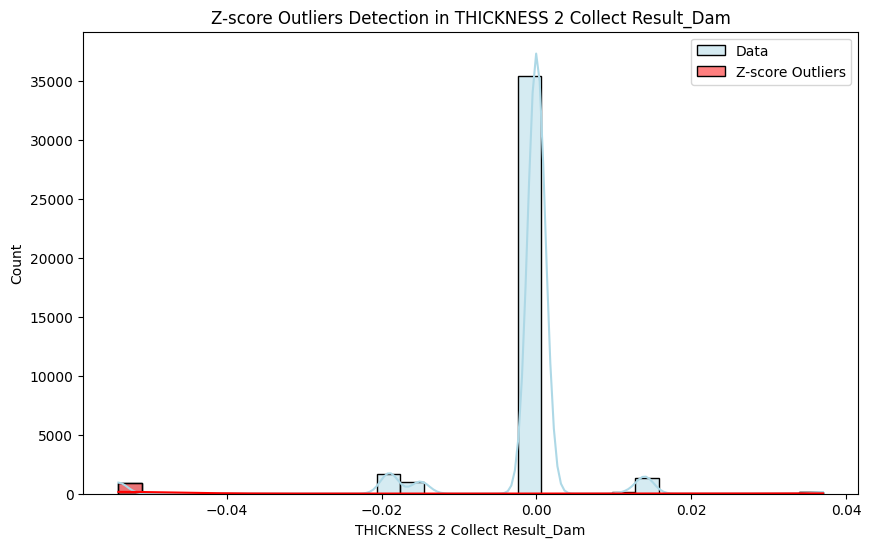

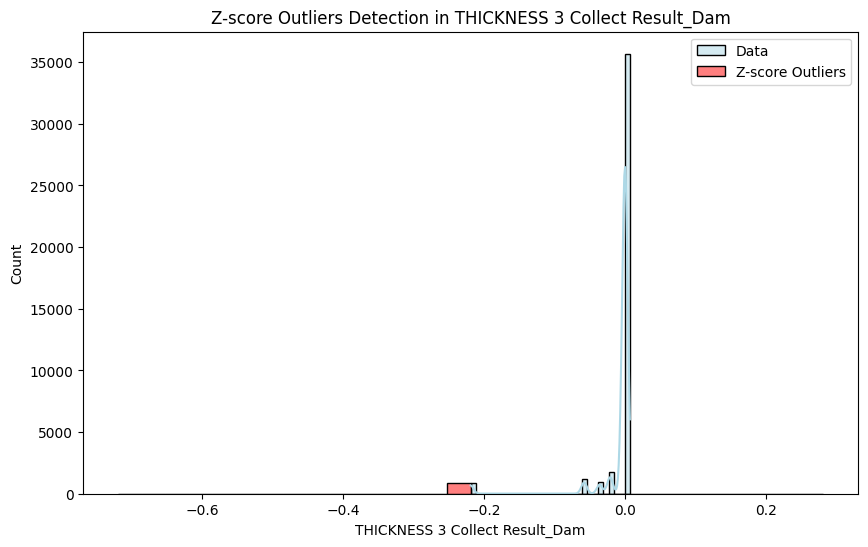

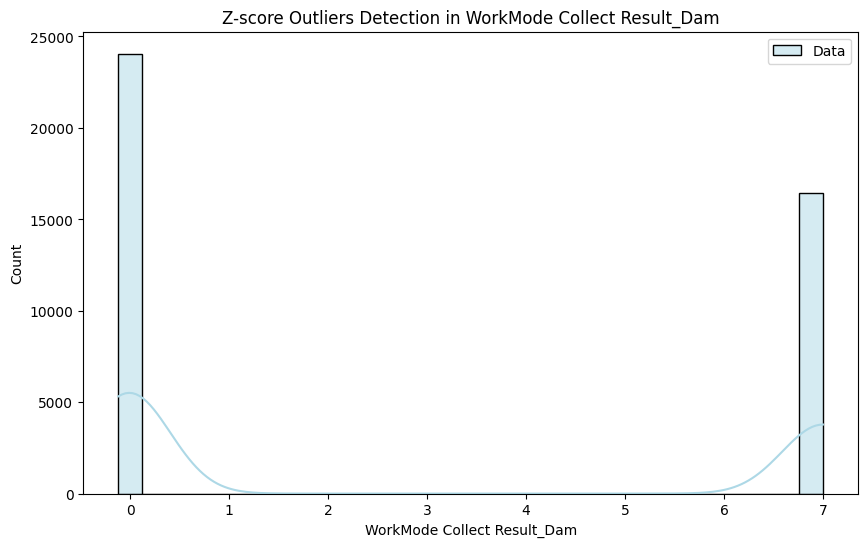

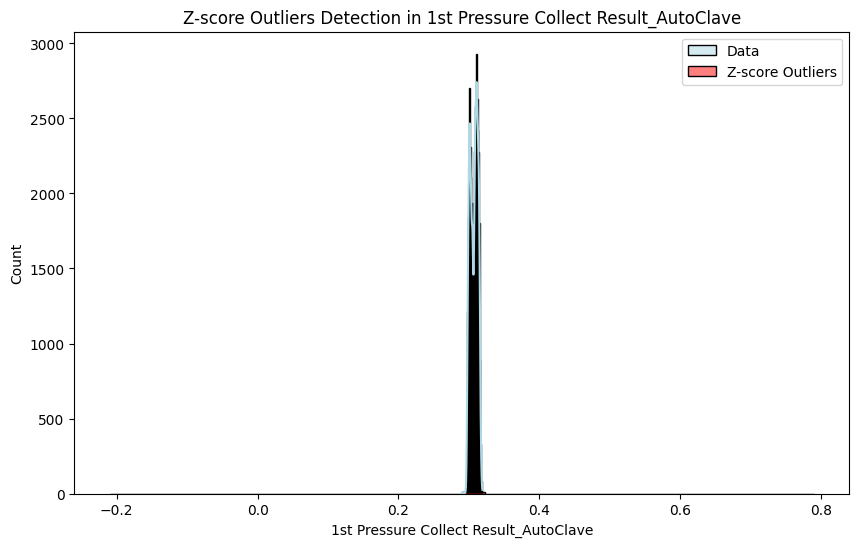

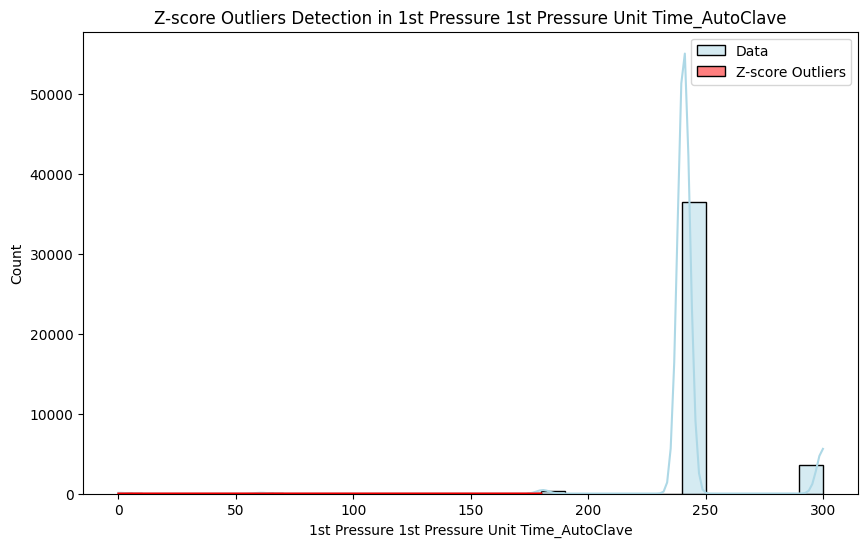

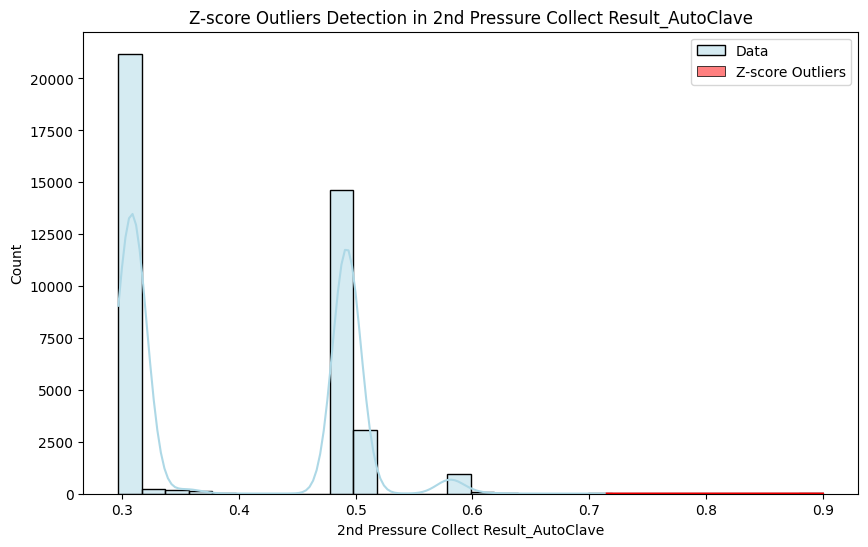

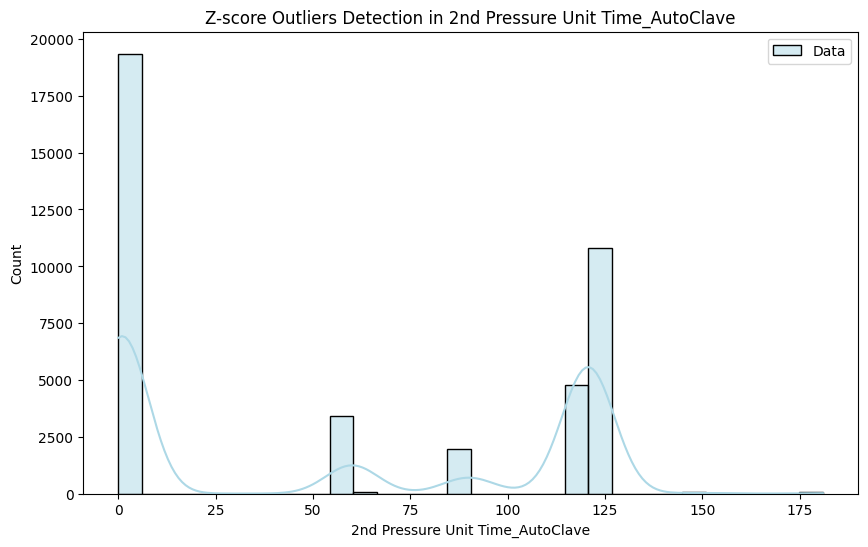

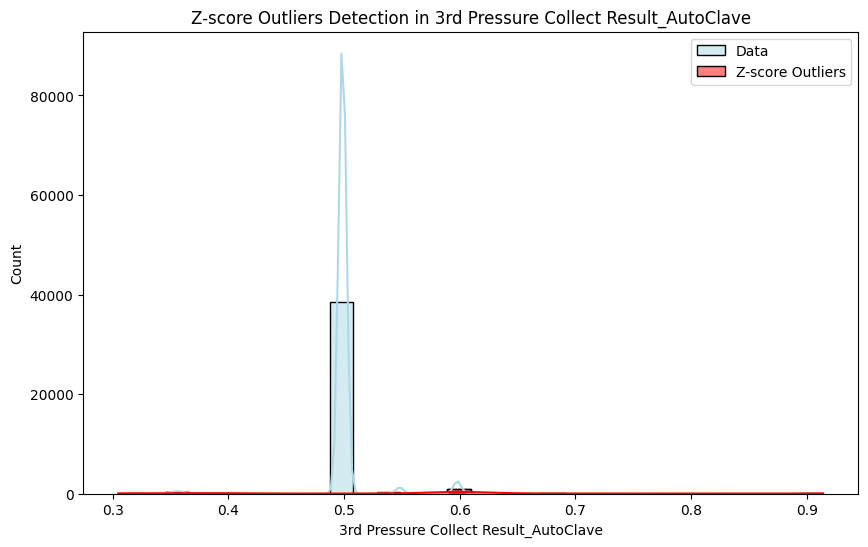

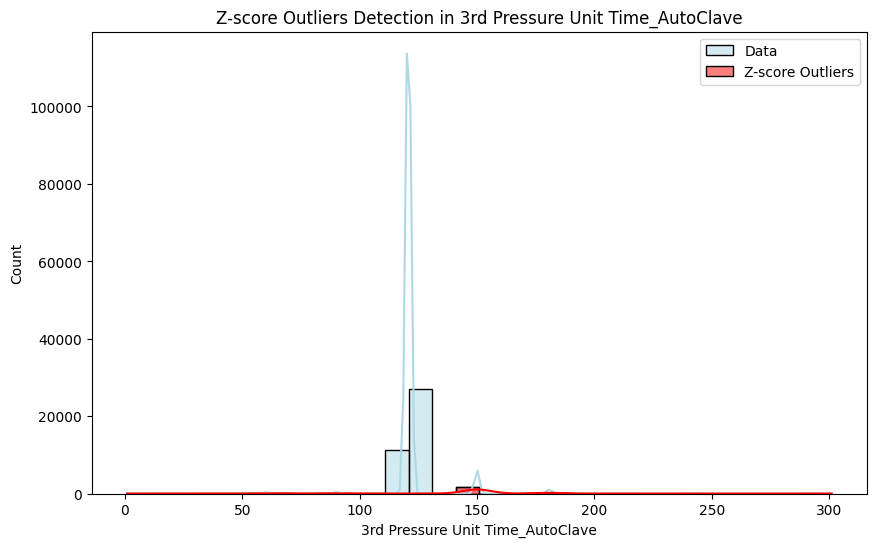

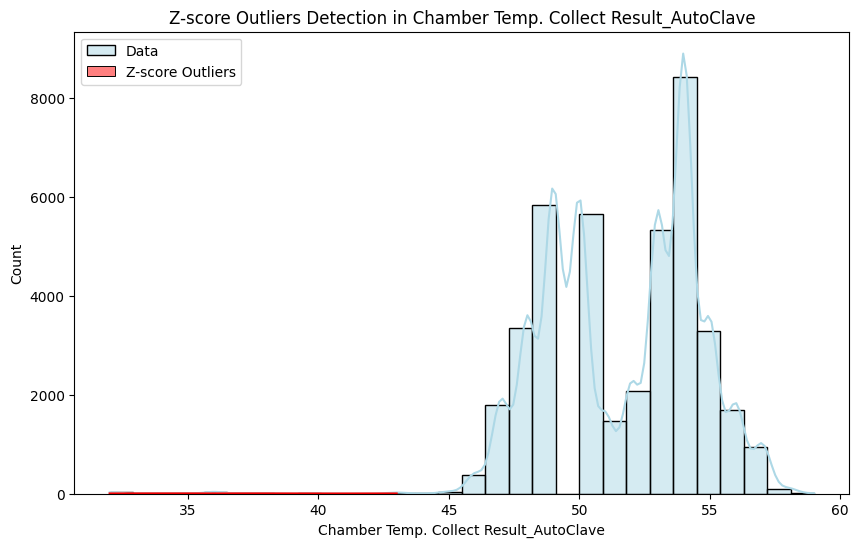

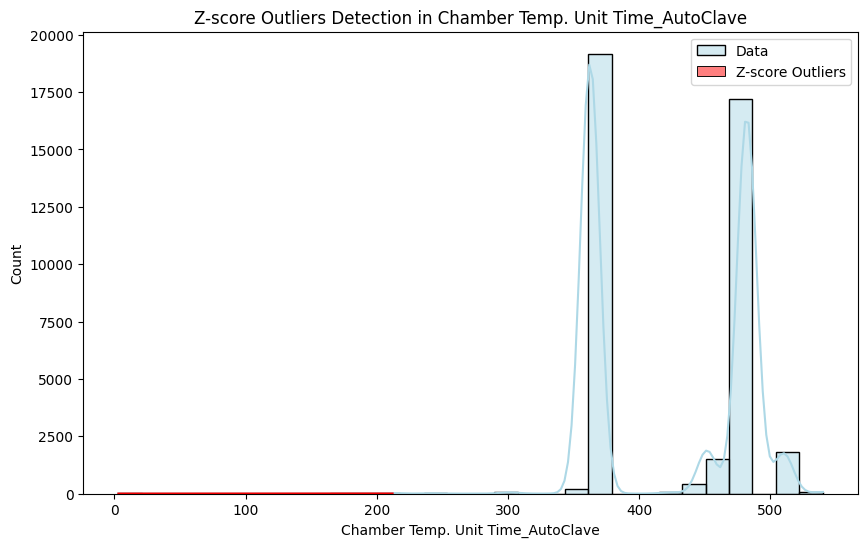

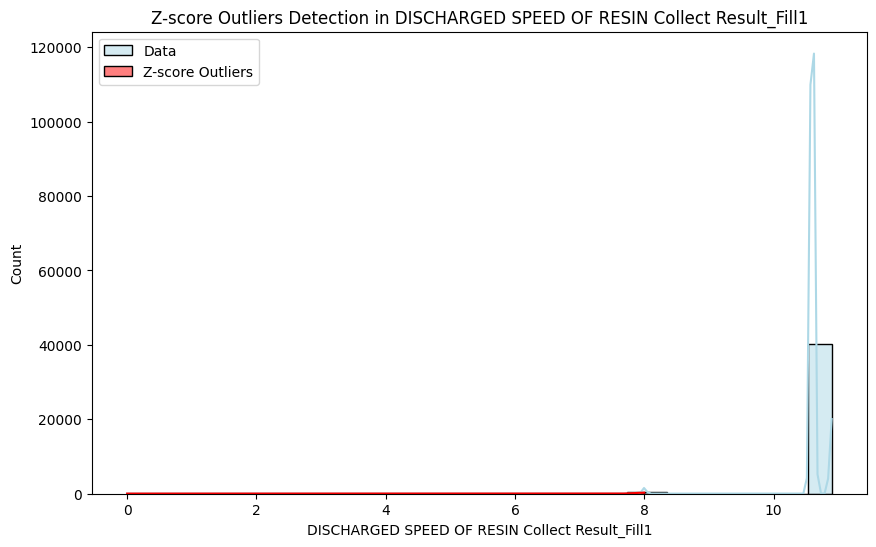

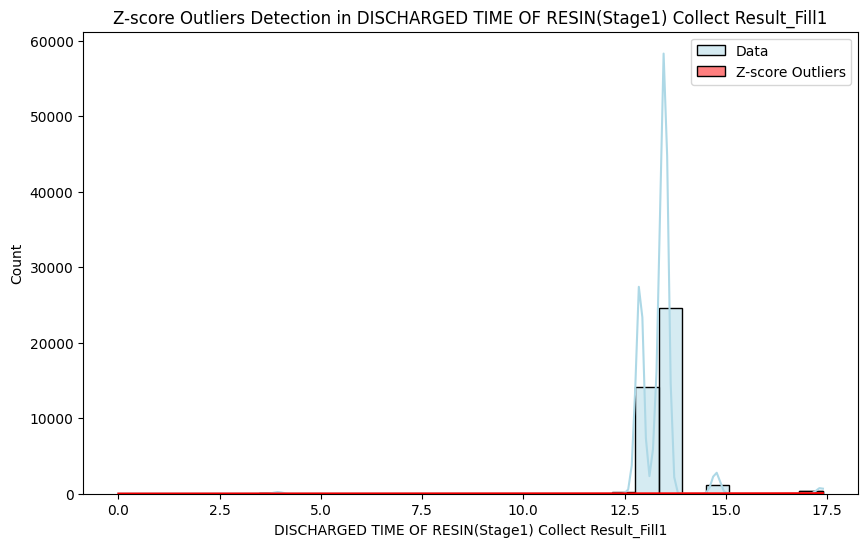

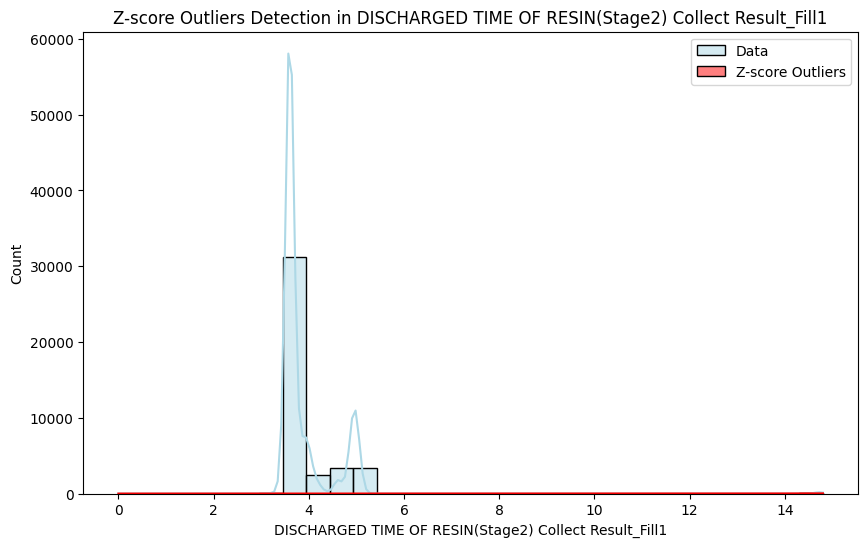

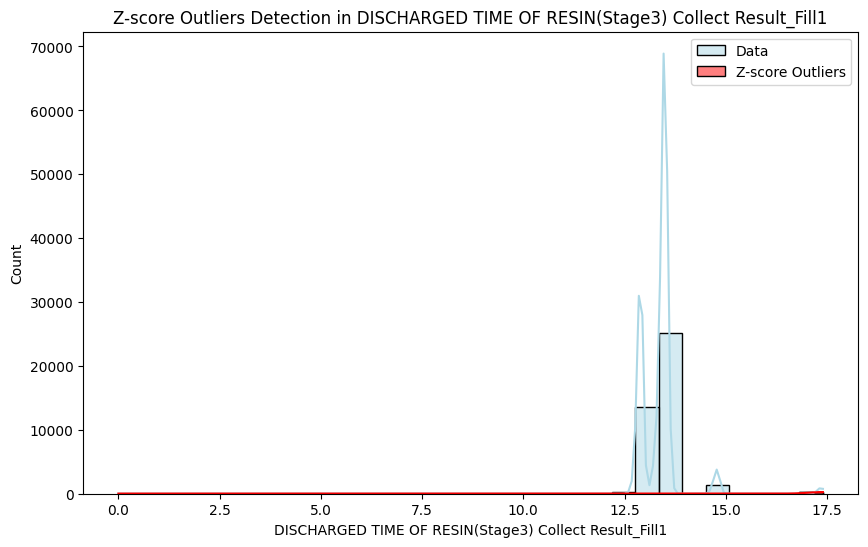

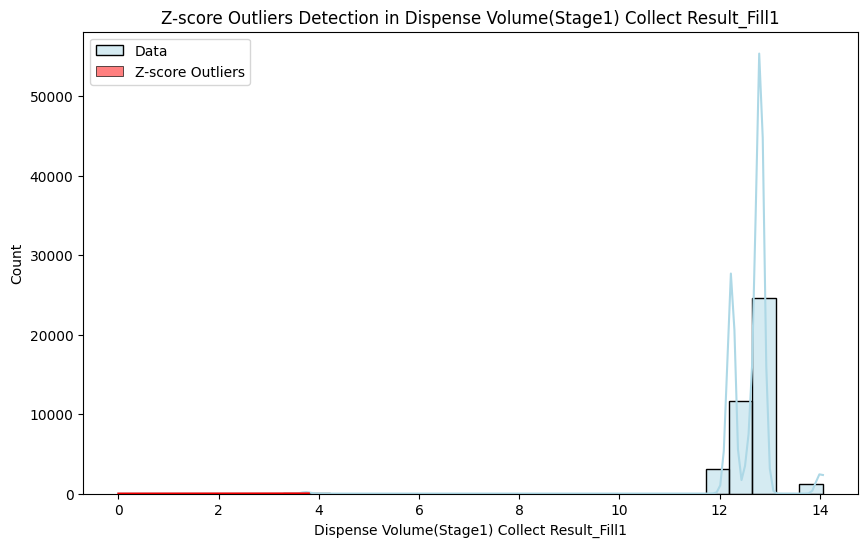

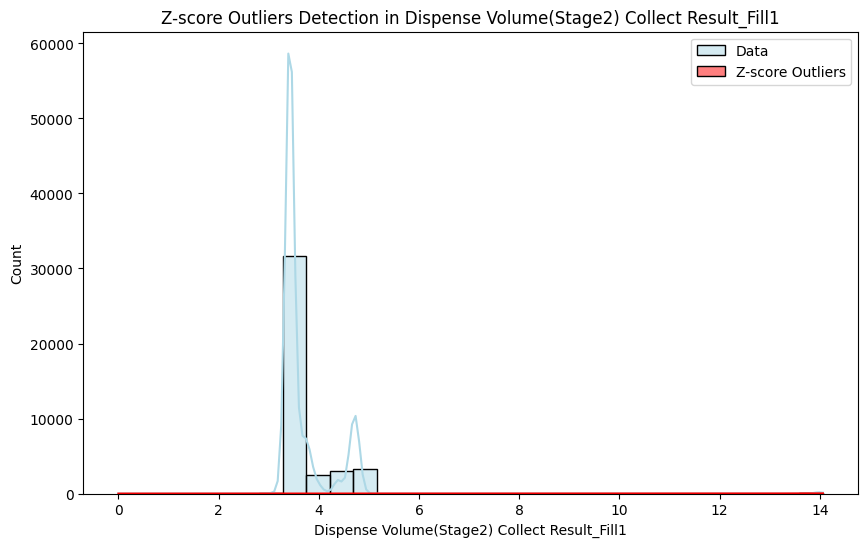

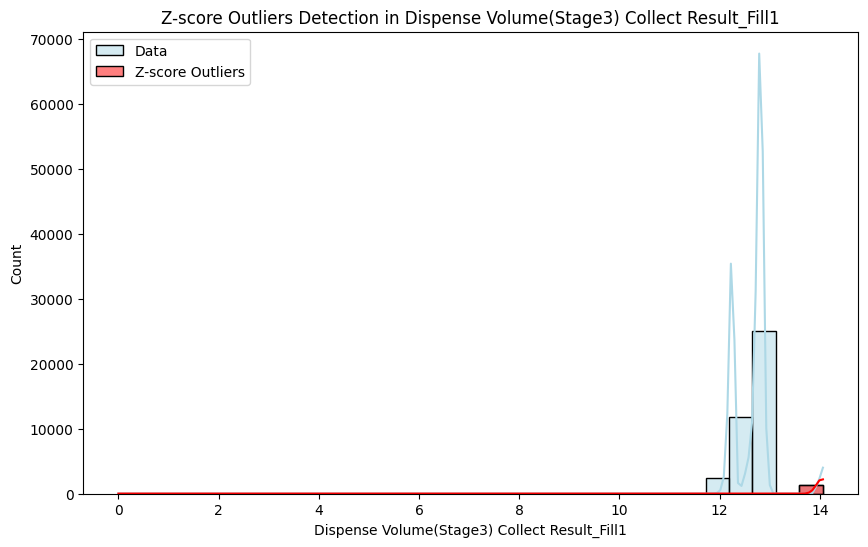

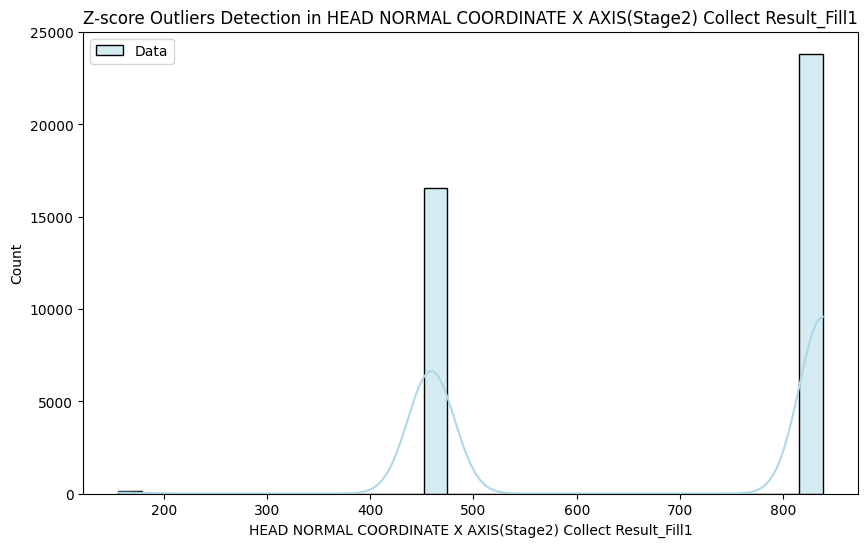

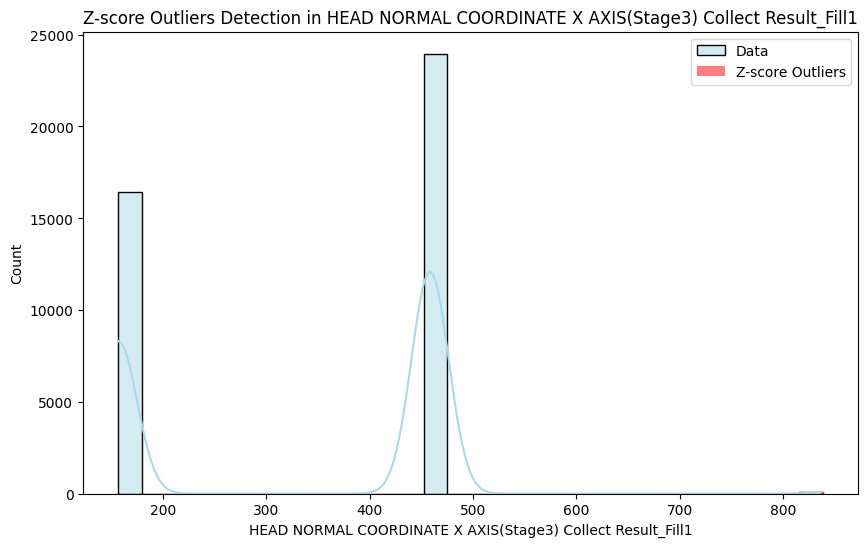

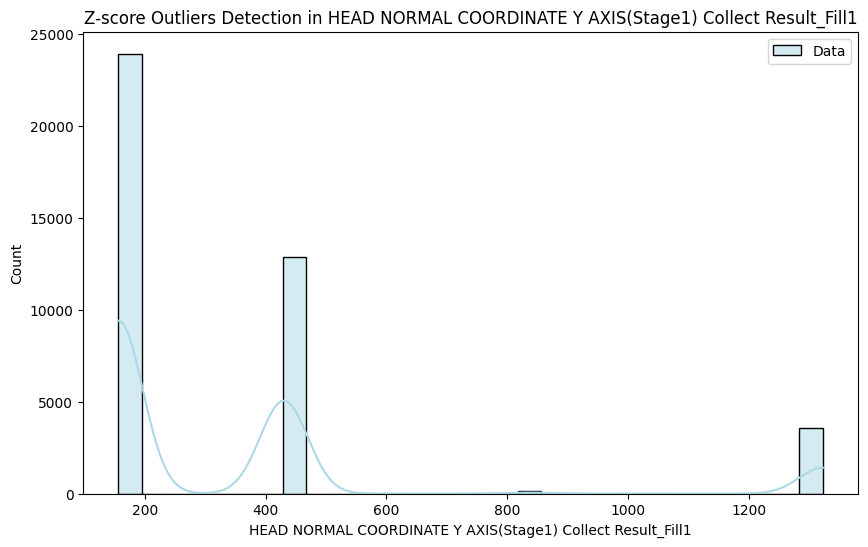

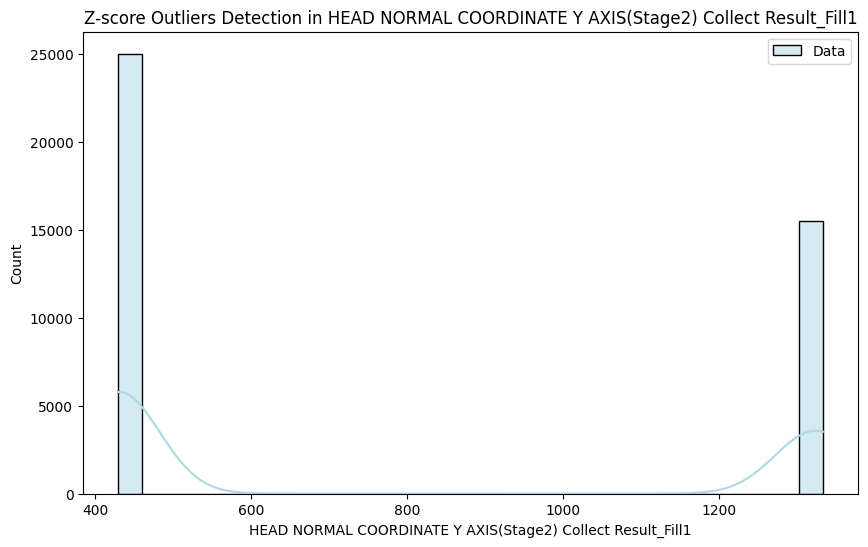

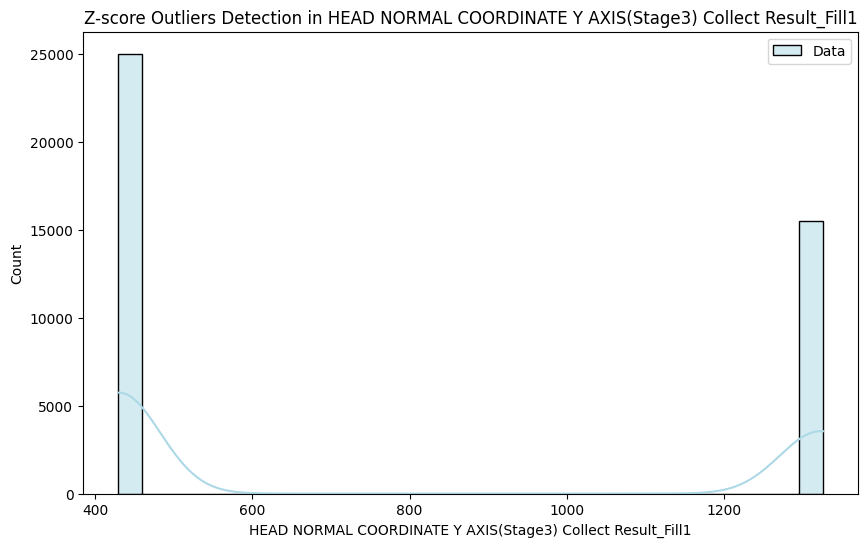

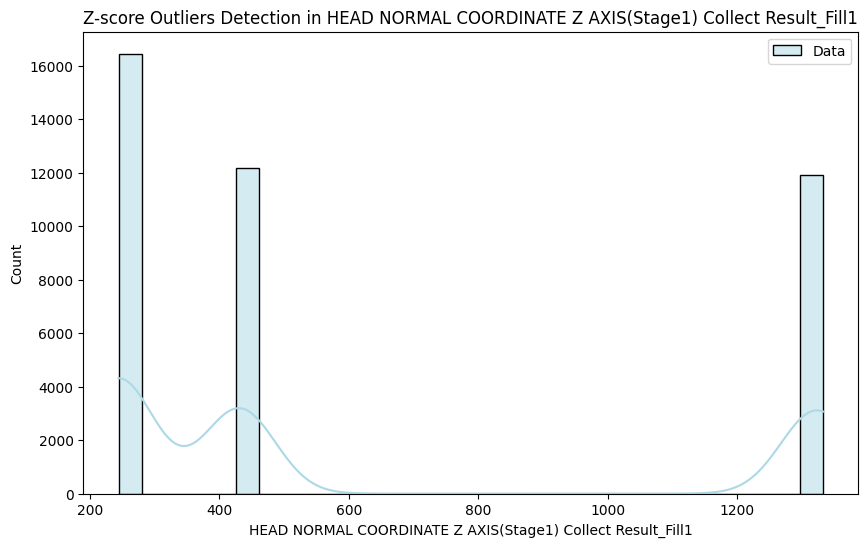

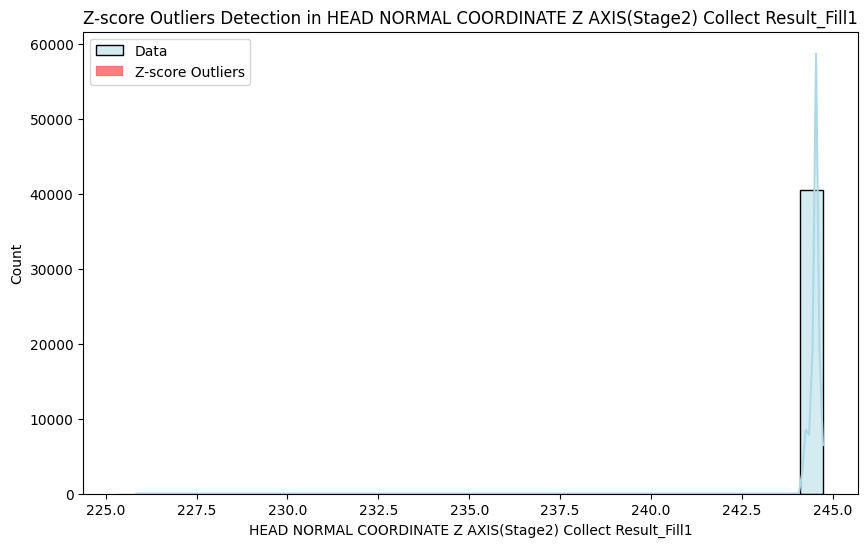

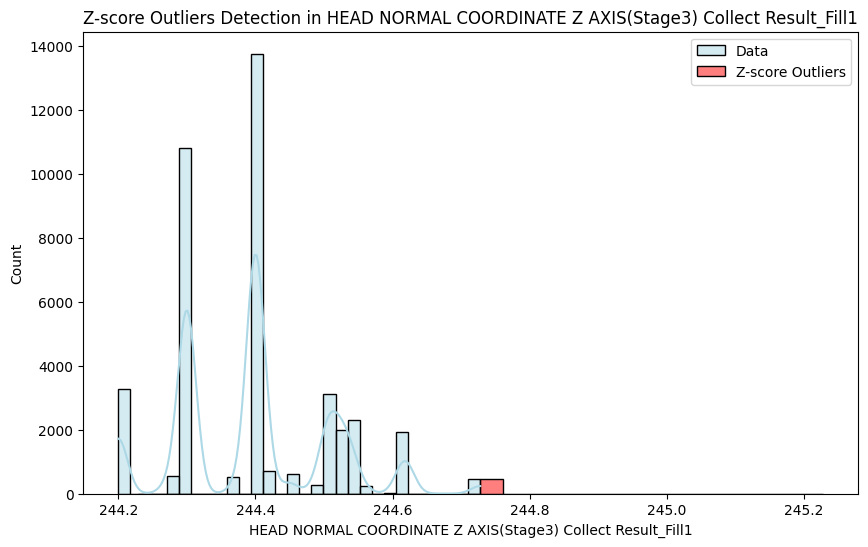

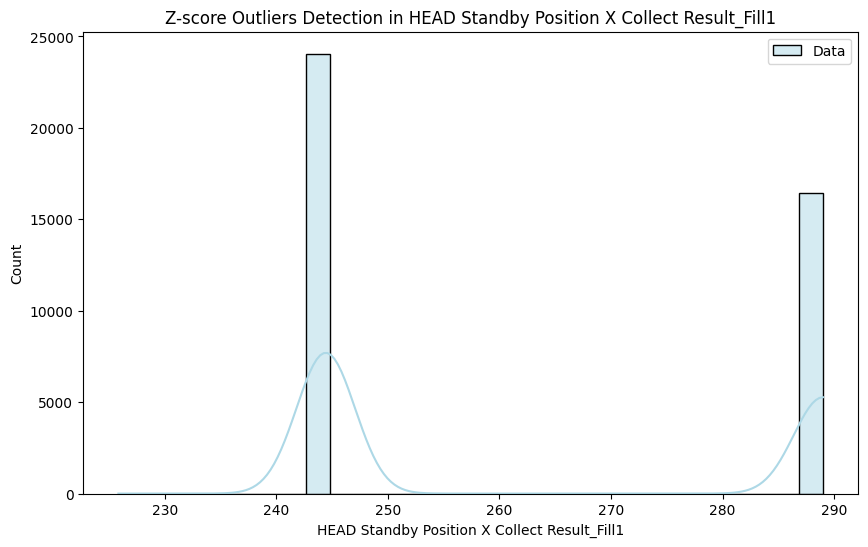

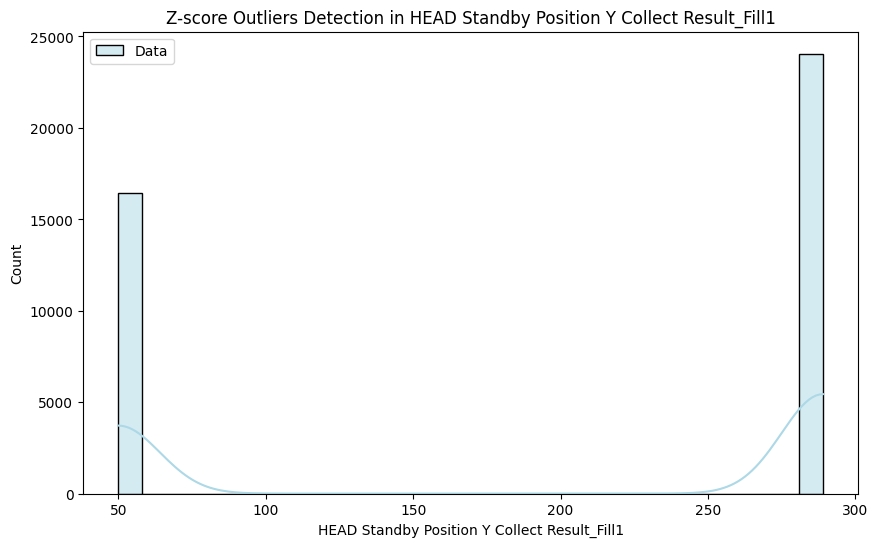

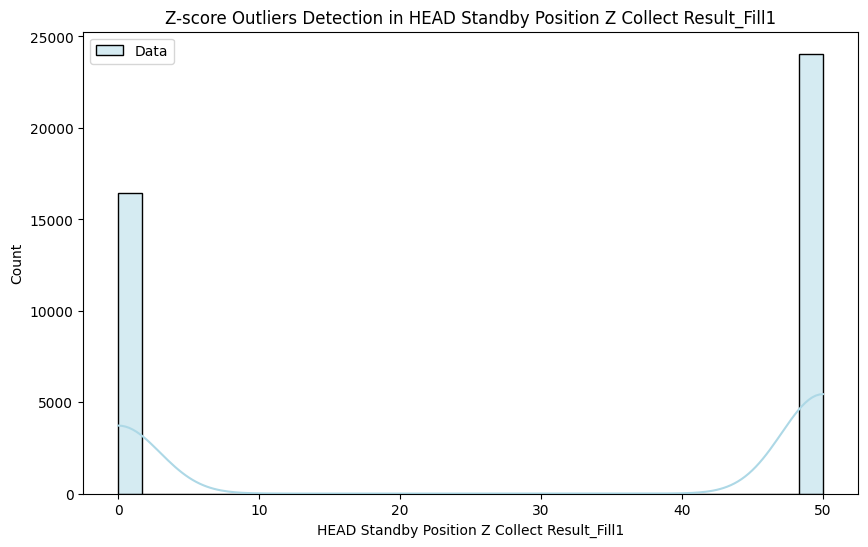

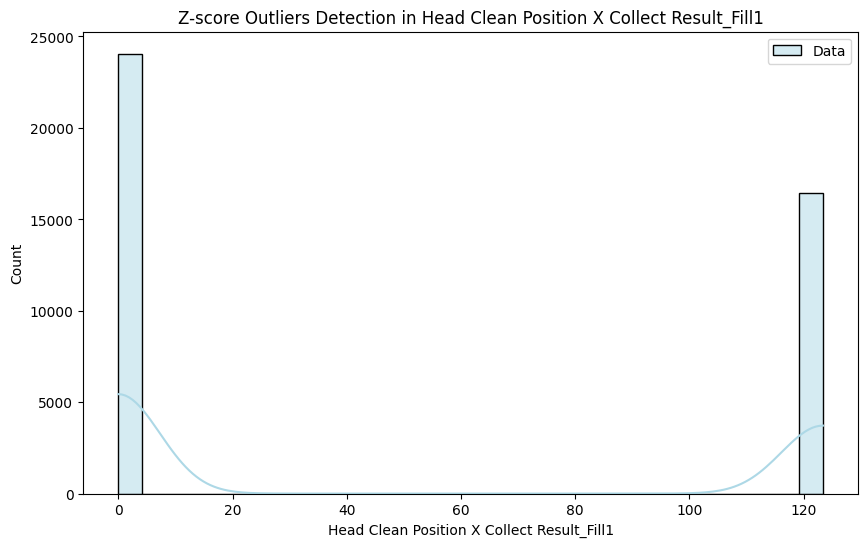

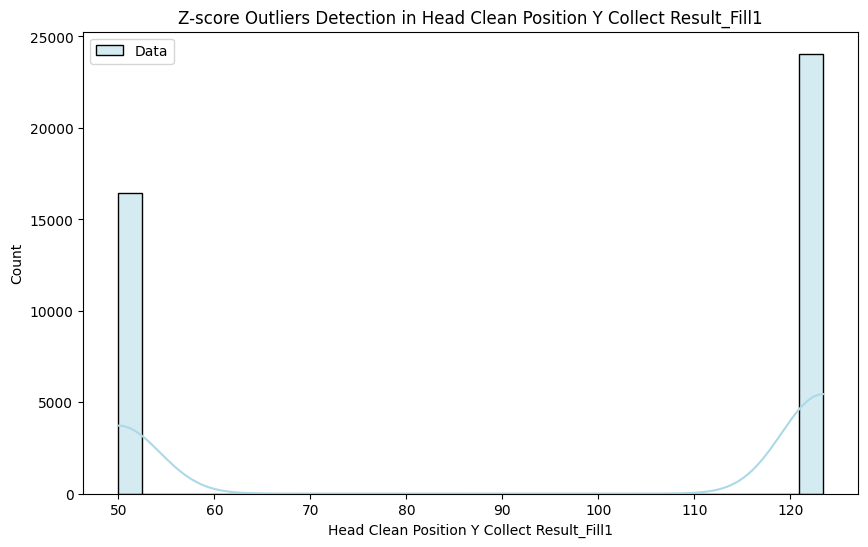

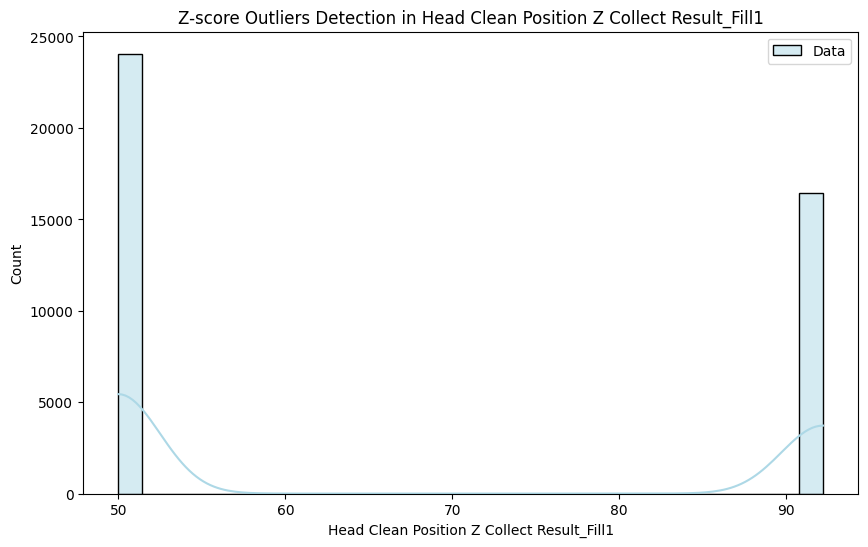

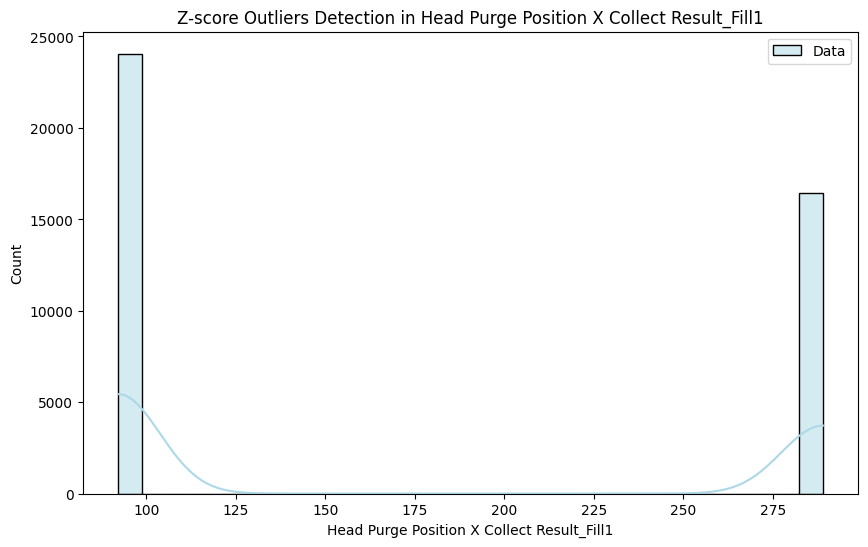

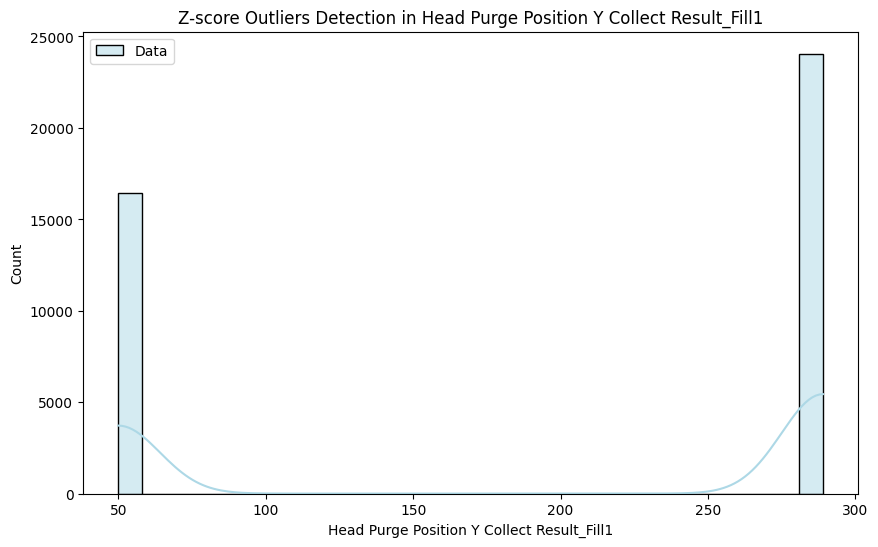

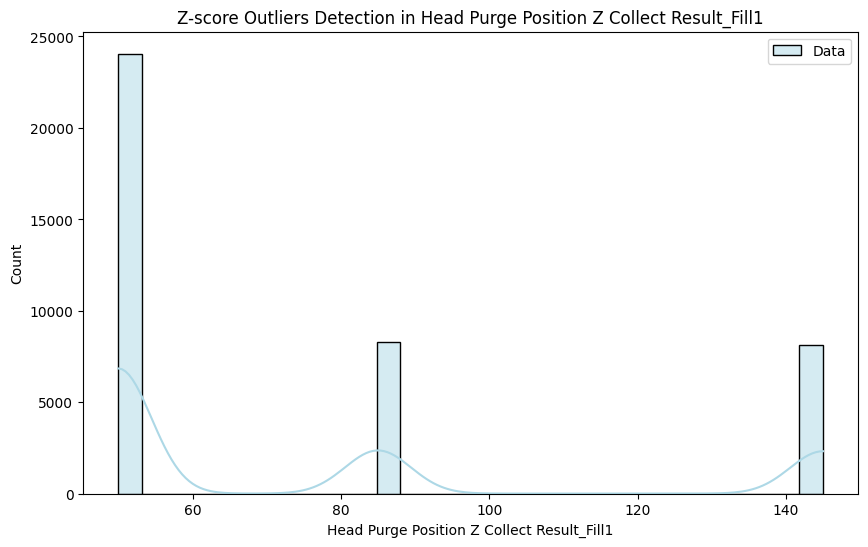

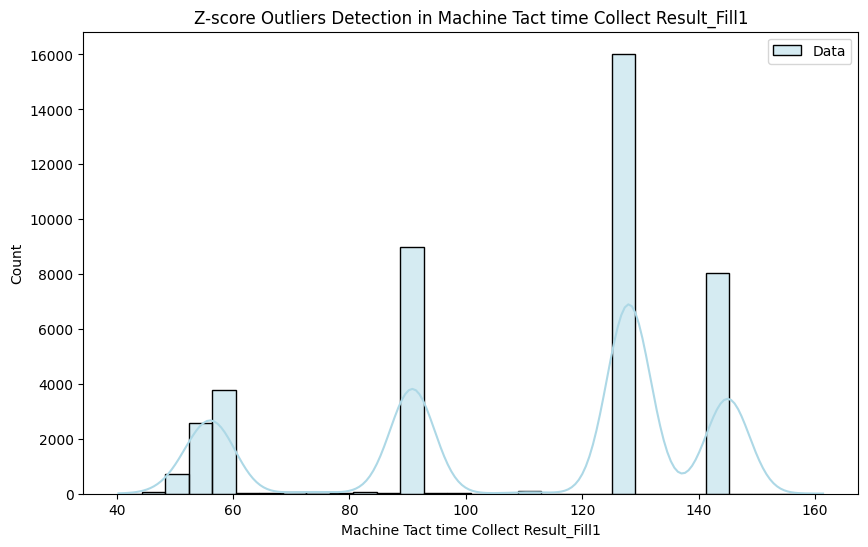

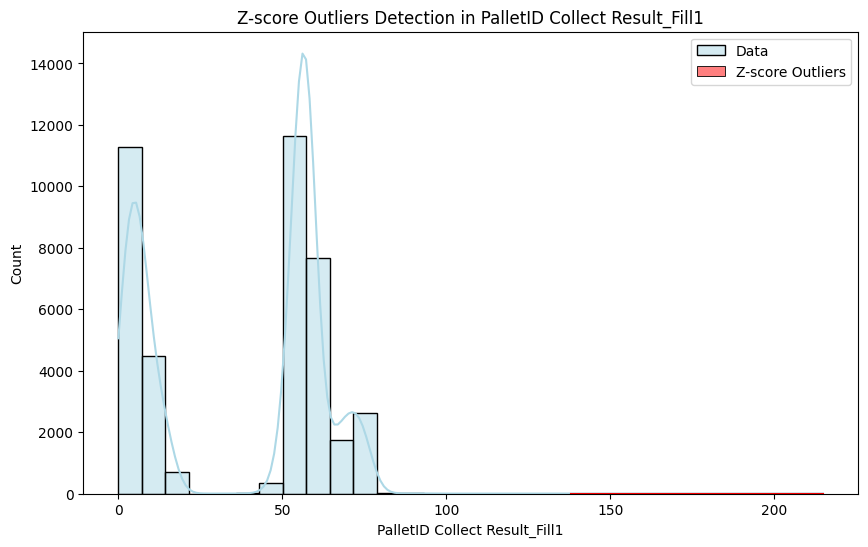

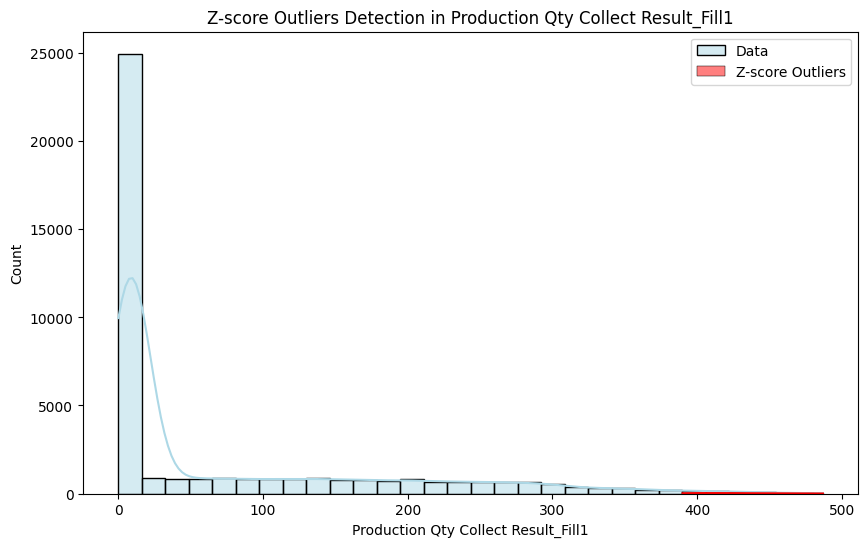

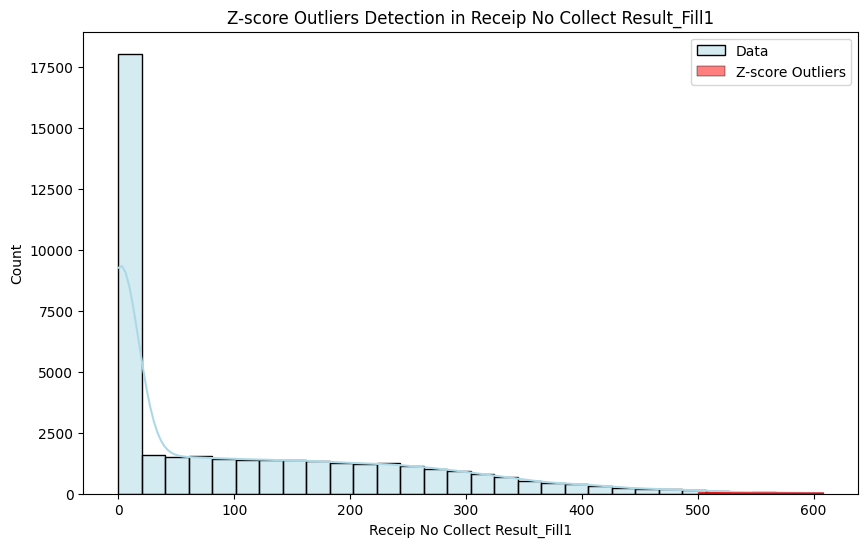

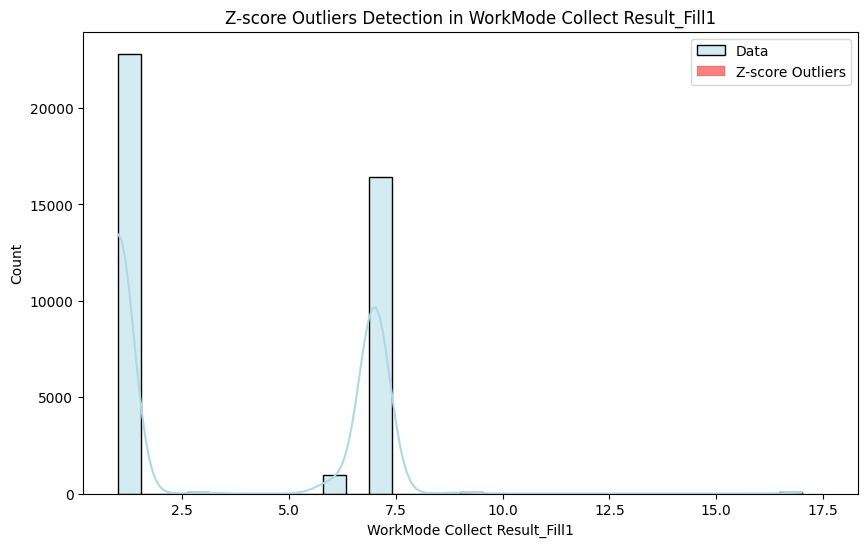

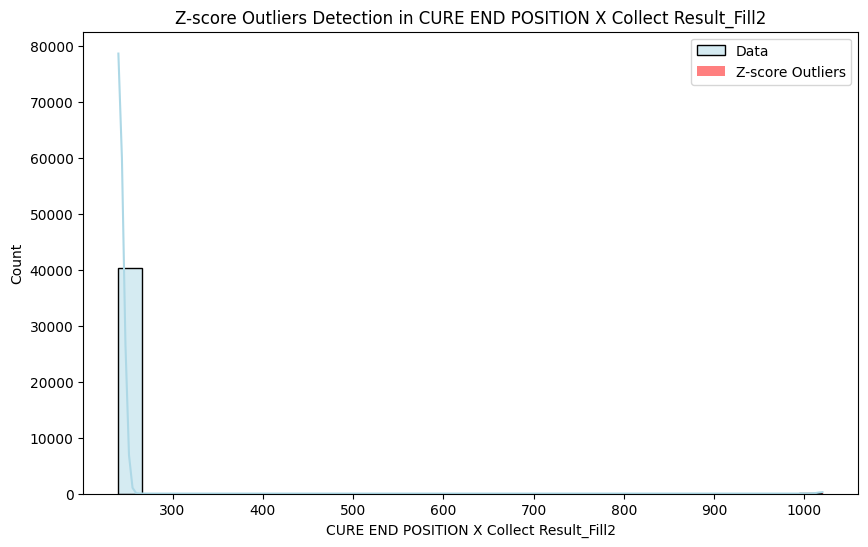

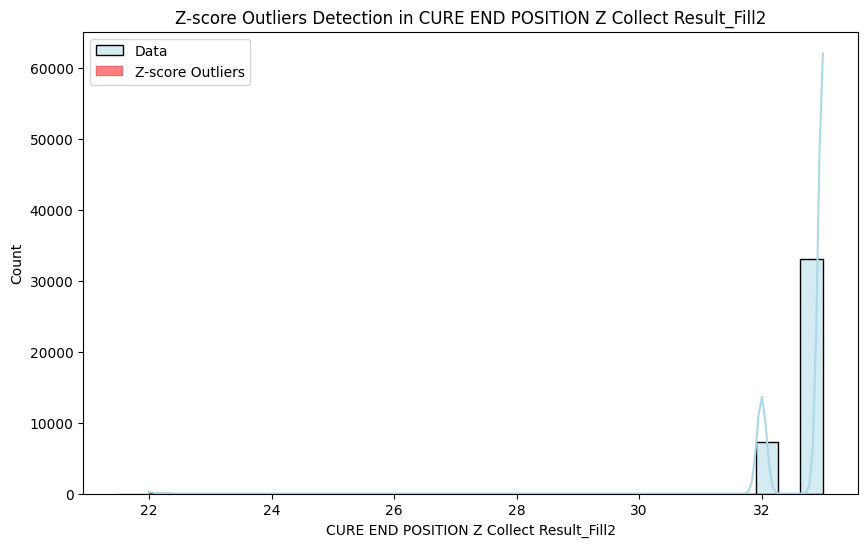

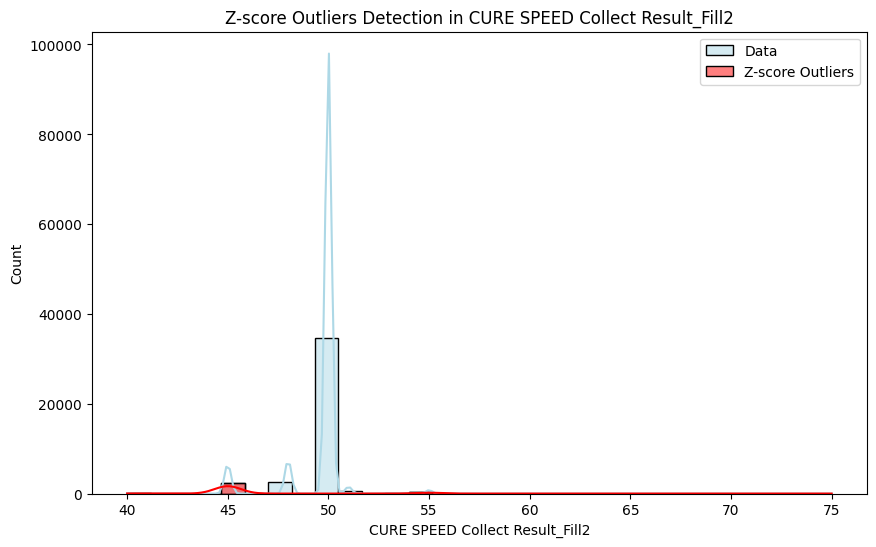

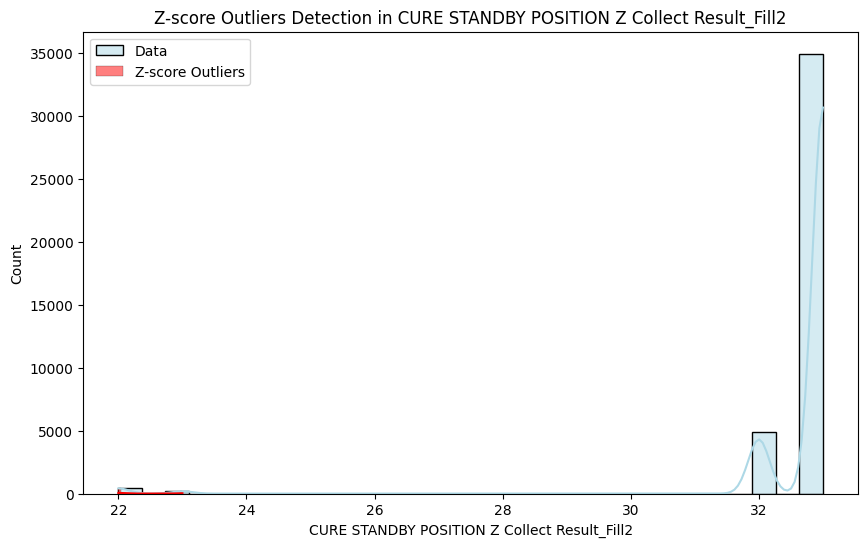

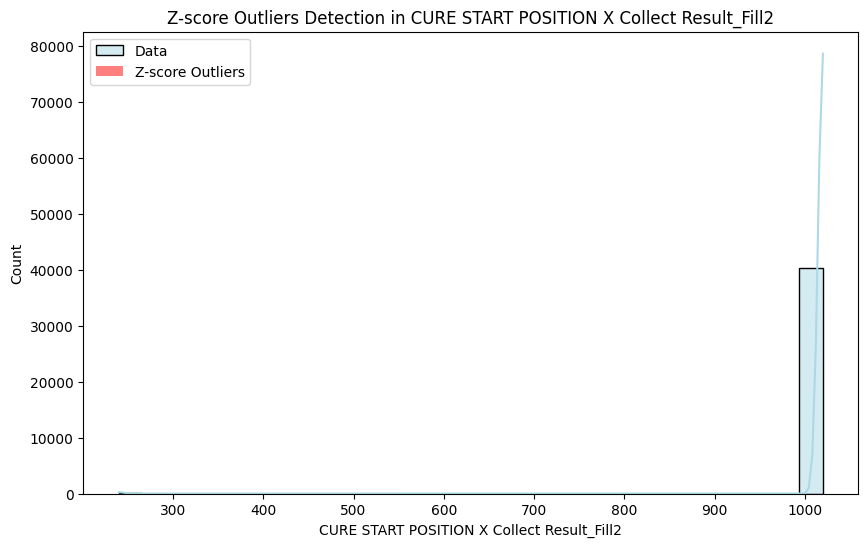

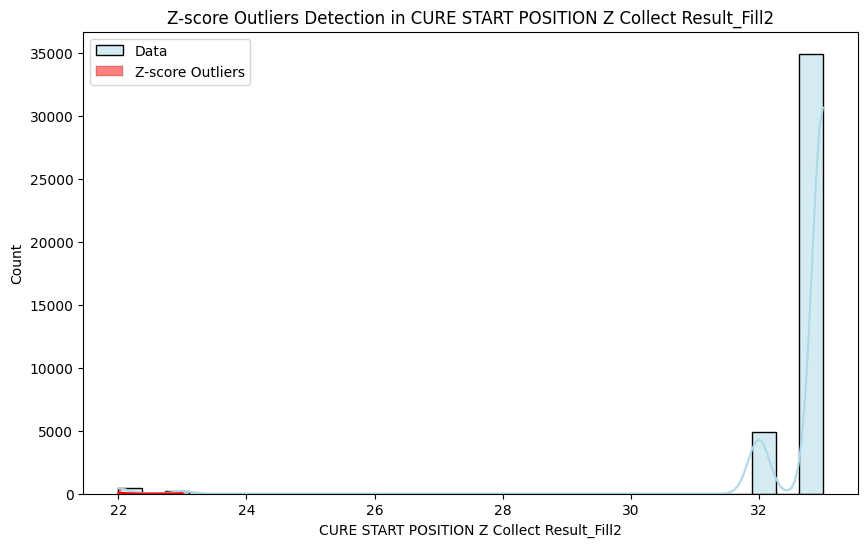

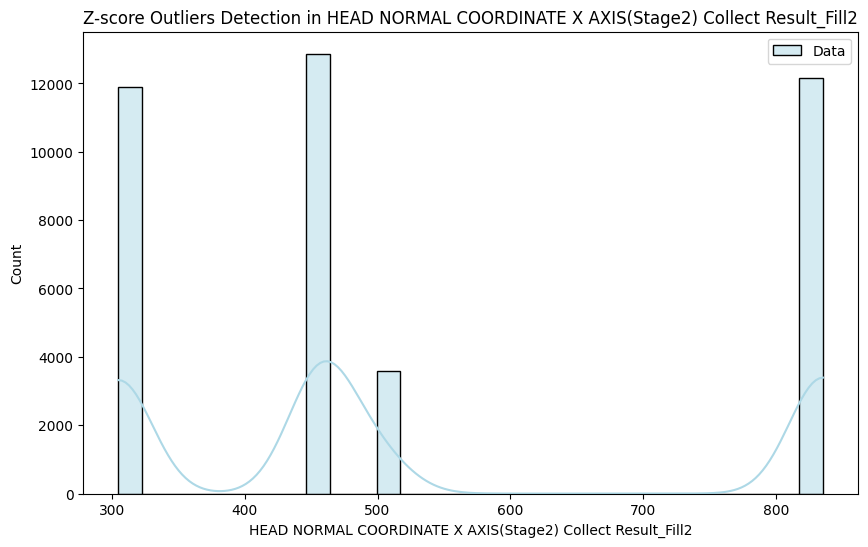

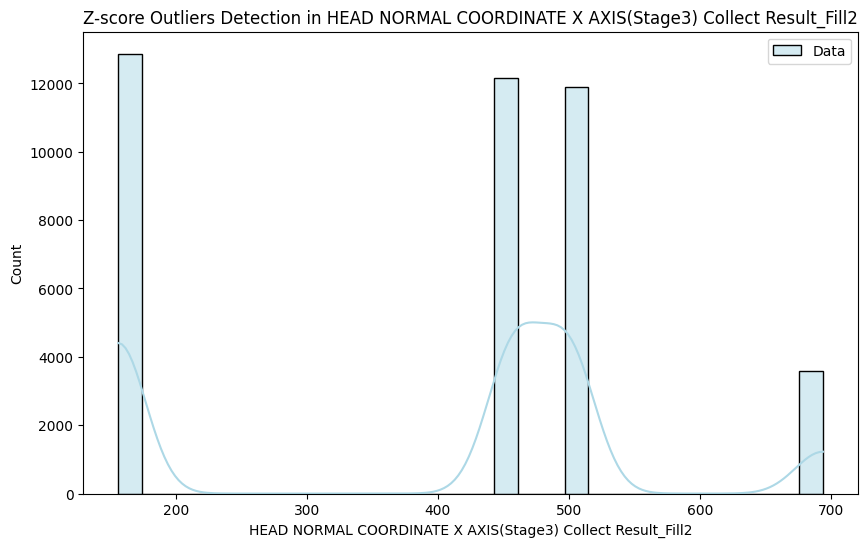

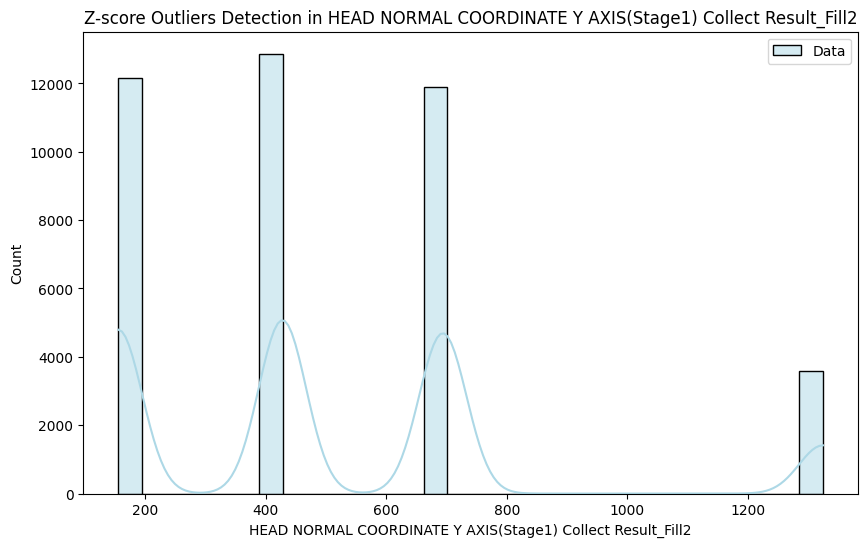

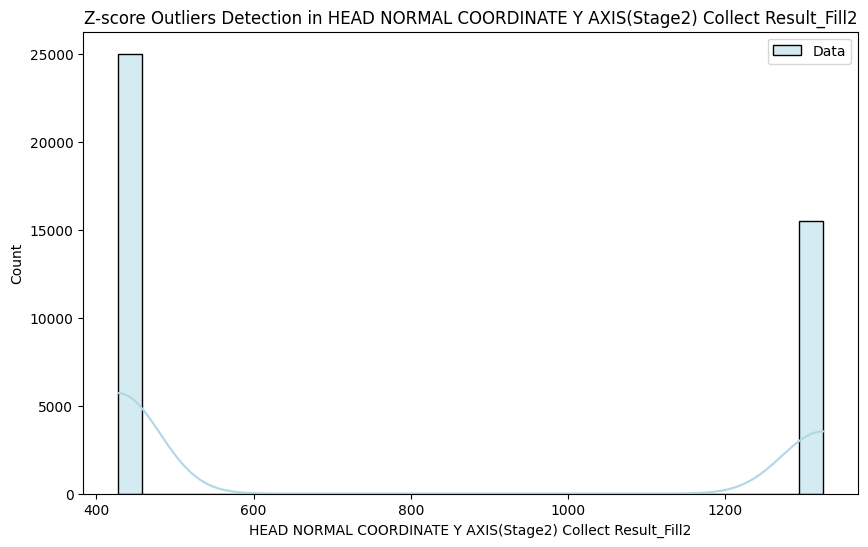

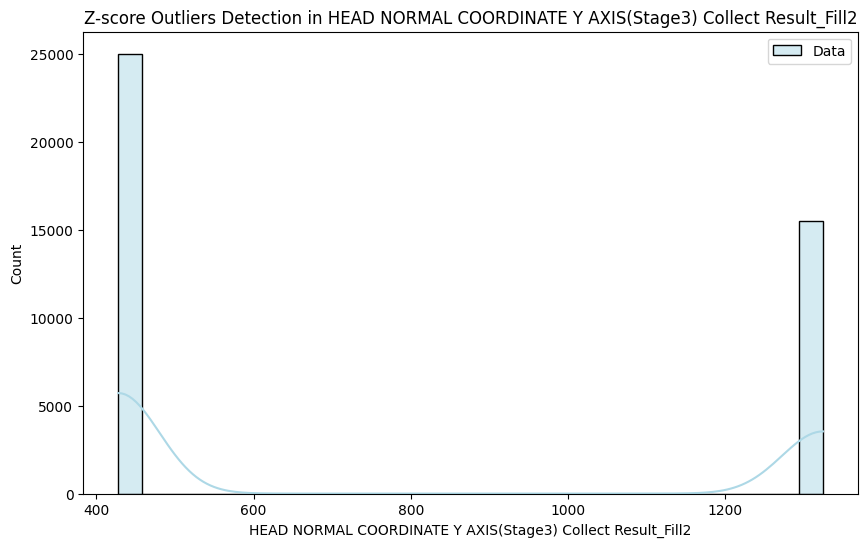

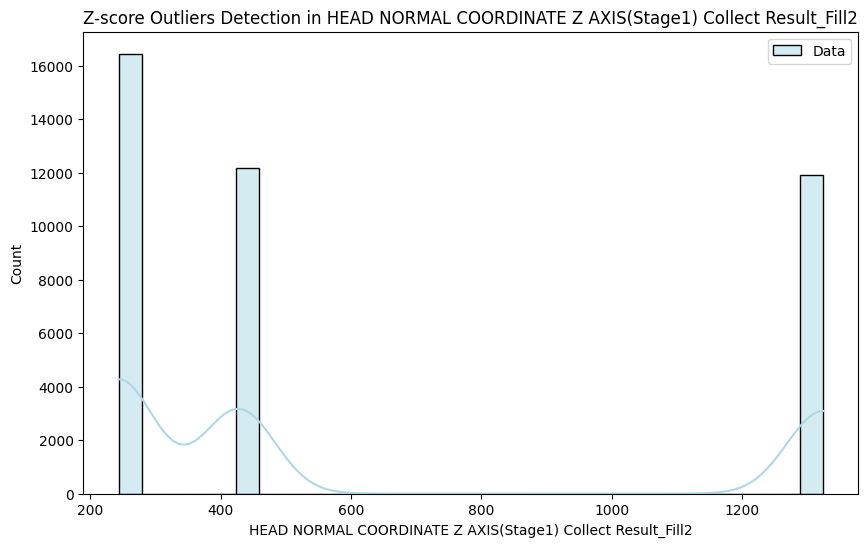

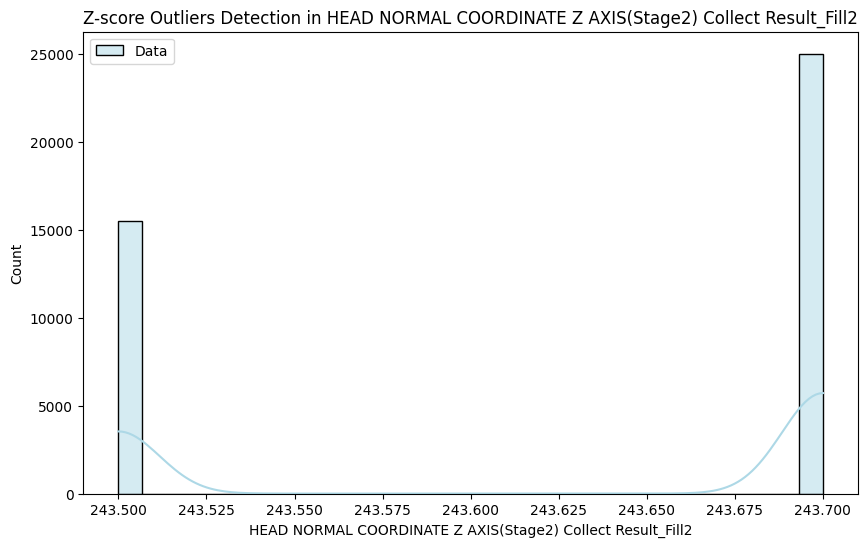

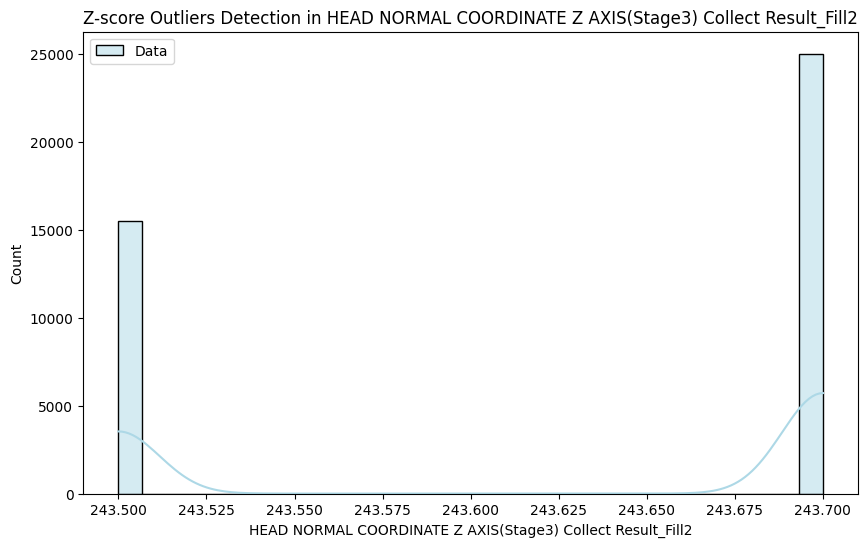

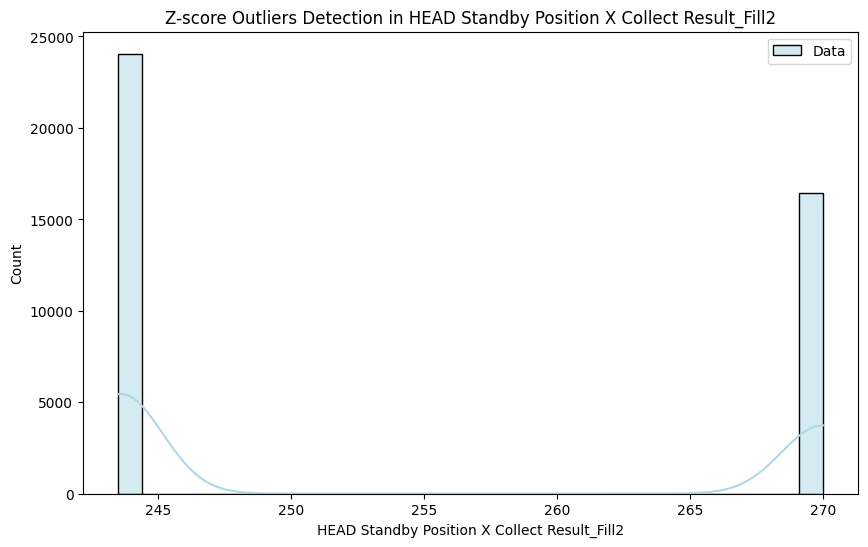

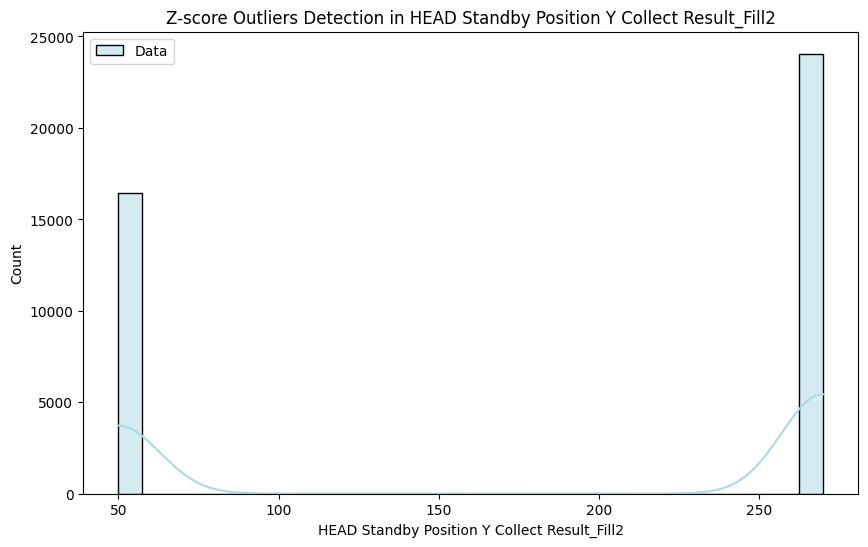

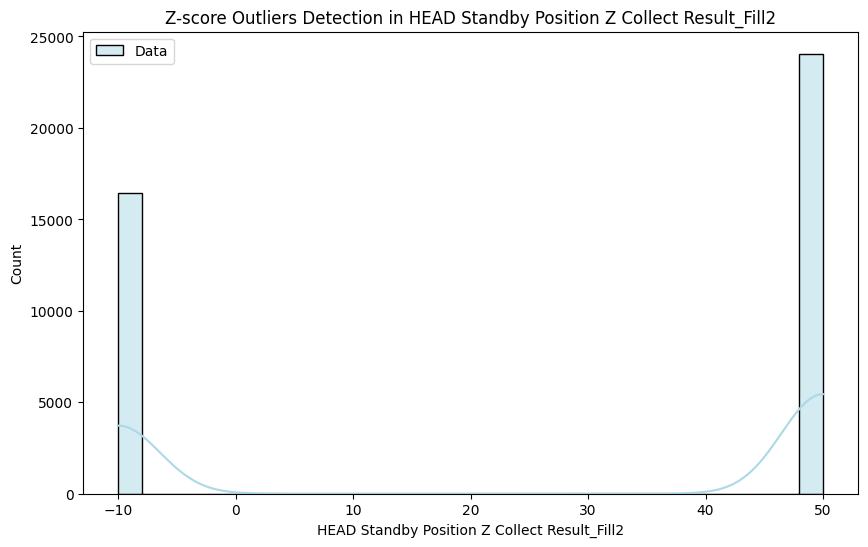

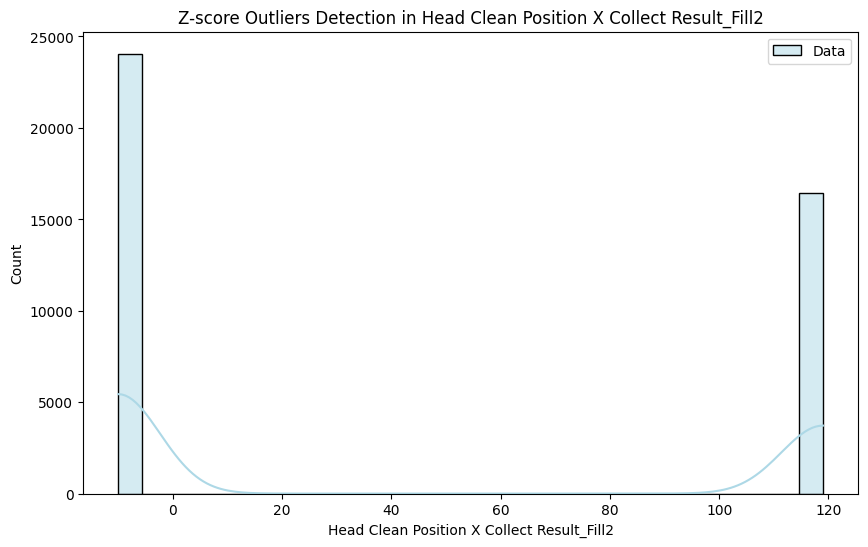

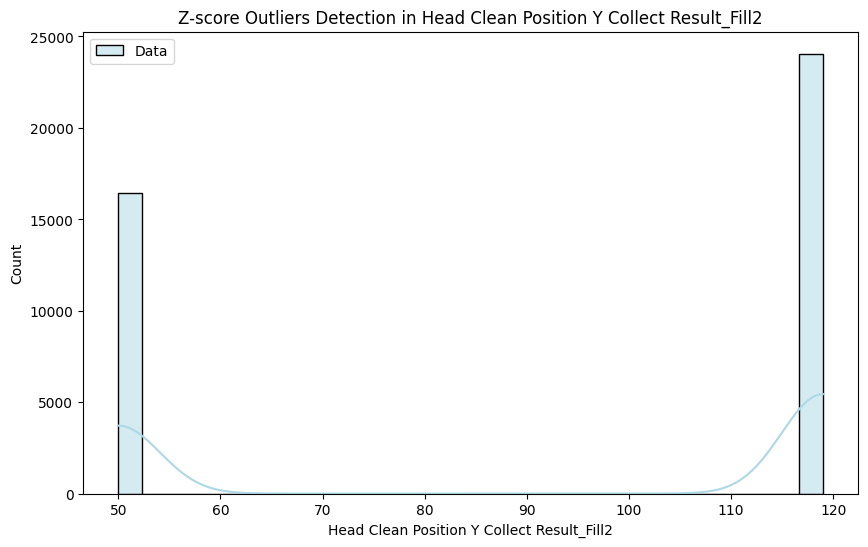

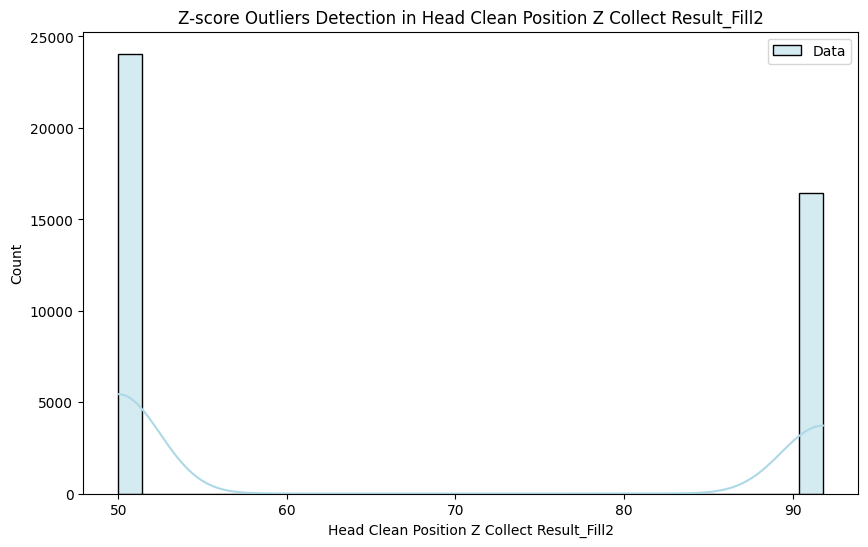

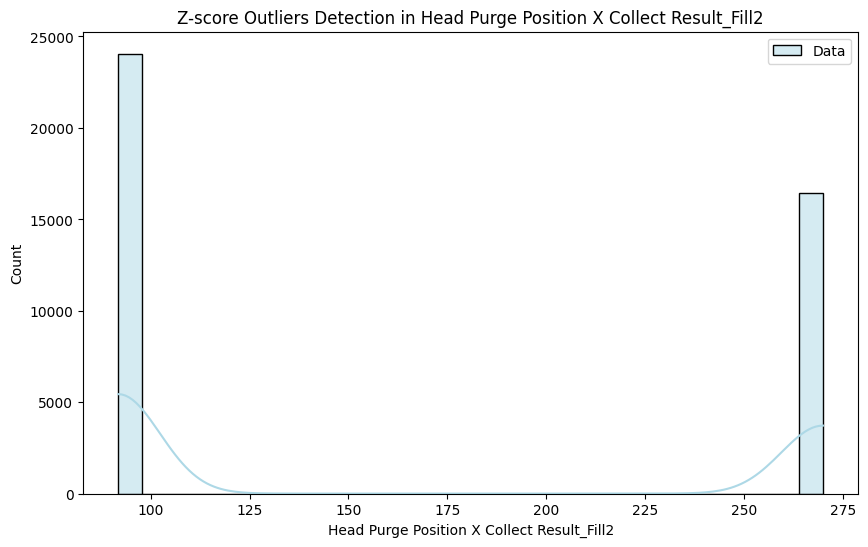

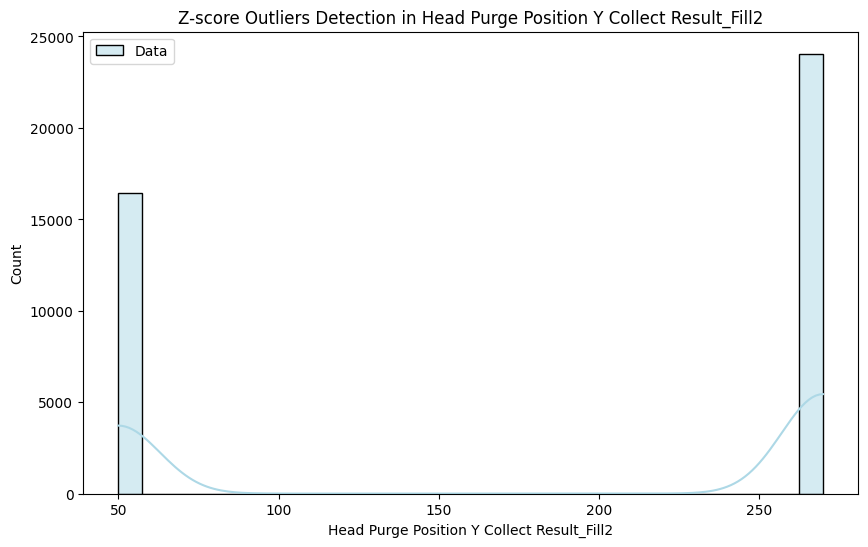

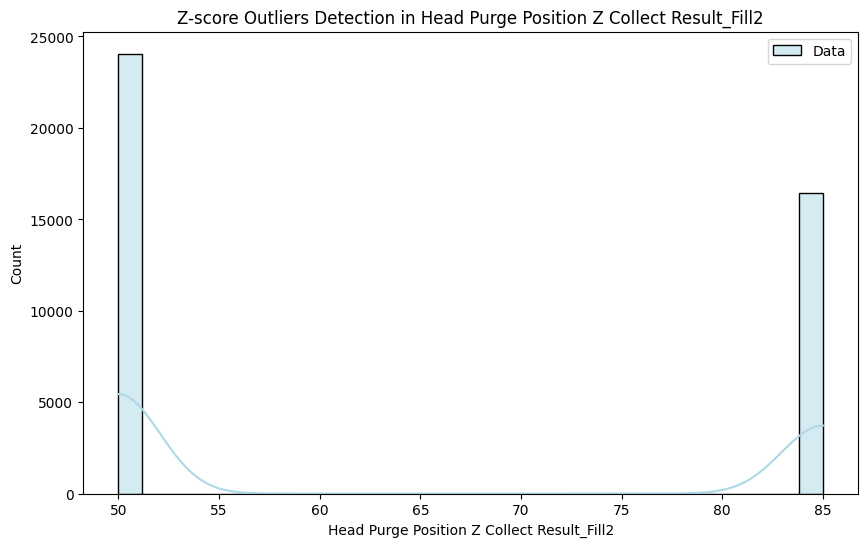

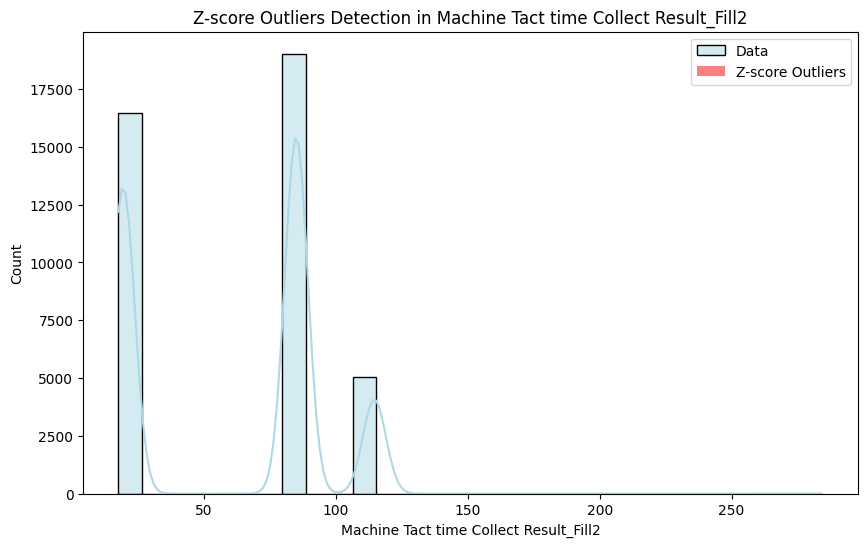

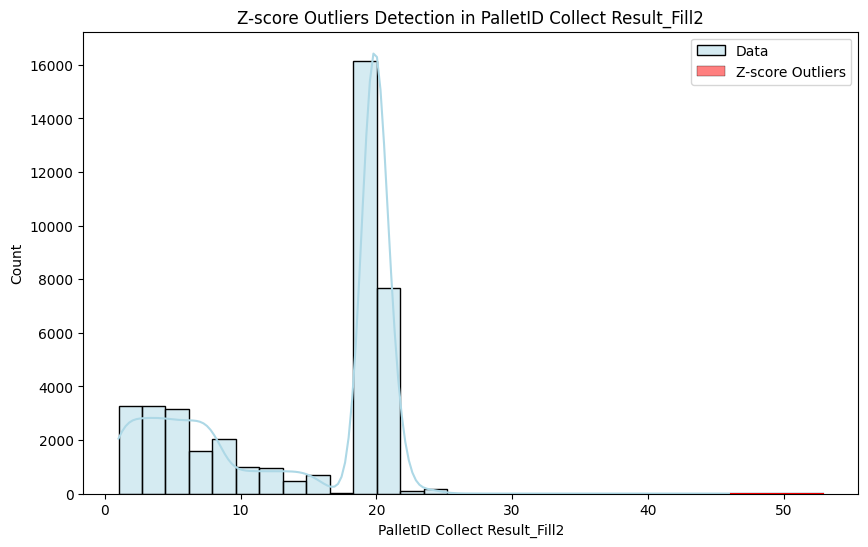

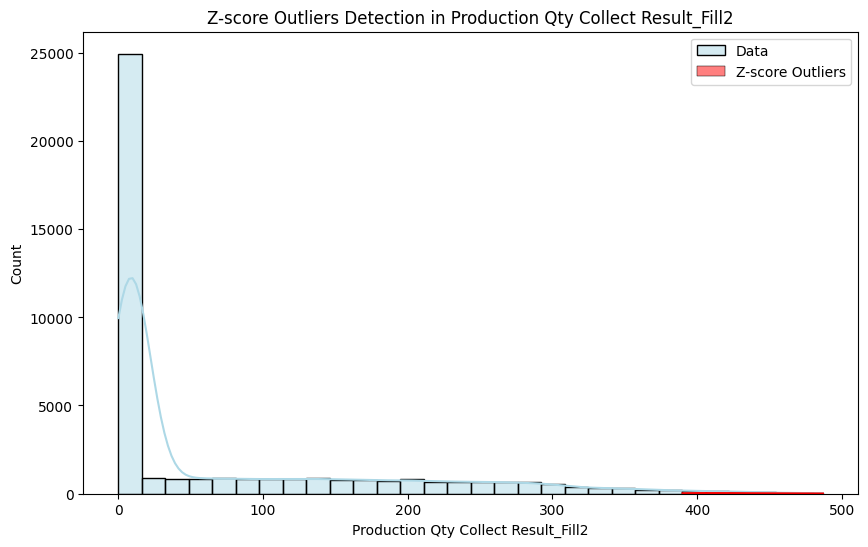

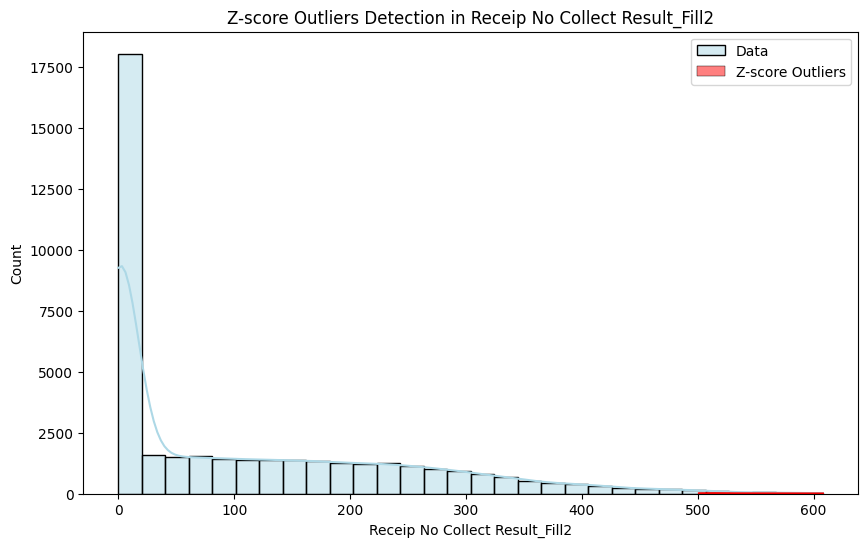

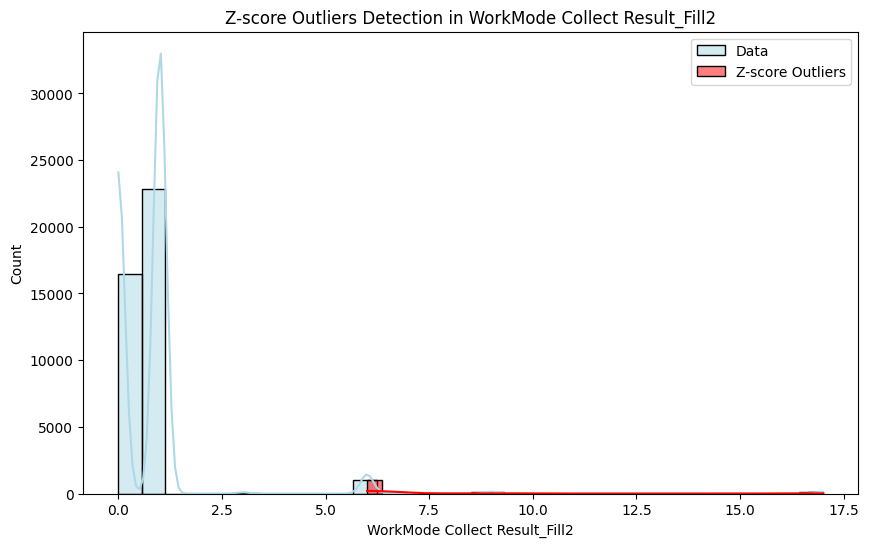

In [187]:
# 이상치 탐지(z-score)
def detect_outliers_zscore(data):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > 3

# 히스토그램 시각화
for column in train_cleaned.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    
    # Z-score 이상치 탐지
    outliers_zscore = detect_outliers_zscore(train_cleaned[column])
    
    # 전체 데이터 히스토그램 시각화
    sns.histplot(train_cleaned[column], kde=True, color='lightblue', label='Data', bins=30)
    
    # 이상치 데이터 히스토그램 시각화
    sns.histplot(train_cleaned.loc[outliers_zscore, column], kde=True, color='red', label='Z-score Outliers', bins=30)
    
    plt.title(f'Z-score Outliers Detection in {column}')
    plt.legend()
    plt.show()

### 범주형 변수 원핫인코딩

원핫인코딩 대상 object 데이터 선정

In [188]:
# dtype이 object인 열만 선택
object_columns_data = train_cleaned.select_dtypes(include=['object'])

# dtype이 object인 열 정보 출력
object_columns_data.info(verbose=True, show_counts=True)

# 열 항목 리스트로 저장
object_columns = object_columns_data.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 21 columns):
 #   Column                                                      Non-Null Count  Dtype 
---  ------                                                      --------------  ----- 
 0   Equipment_Dam                                               40506 non-null  object
 1   Model.Suffix_Dam                                            40506 non-null  object
 2   Workorder_Dam                                               40506 non-null  object
 3   HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam    16447 non-null  object
 4   HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam       11293 non-null  object
 5   Model.Suffix_AutoClave                                      40506 non-null  object
 6   Workorder_AutoClave                                         40506 non-null  object
 7   Chamber Temp. Judge Value_AutoClave                         40506 non-null  object
 8   GMES_O

원핫인코딩 대상 숫자 데이터 선정

In [189]:
# 숫자 데이터(int, float)로 이루어진 열 중 원핫인코딩 대상
num_columns = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Receip No Collect Result_Dam',
    'WorkMode Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'PalletID Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'WorkMode Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    # 'CURE END POSITION Θ Collect Result_Fill2', 값이 모든 열 제거에서 제거됨이 확인
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'PalletID Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'WorkMode Collect Result_Fill2',
]

원핫인코딩 대상 object, 숫자 데이터 원핫인코딩 

In [191]:
# dtype이 object인 열과 원핫인코딩이 필요한 숫자형 열 합치기
columns_to_encode = object_columns + num_columns
print(columns_to_encode)

# 원핫 인코딩 수행
train_cleaned_encoded = pd.get_dummies(train_cleaned, columns=columns_to_encode, drop_first=True, dtype=int)

# 원핫 인코딩 수행 데이터 저장경로 설정
train_cleaned_encoded_save_path = os.path.join(ROOT_DIR, "train_cleaned_encoded.csv")

# 수정된 데이터 저장(100mb초과로 막았습니다.)
# train_cleaned_encoded.to_csv(train_cleaned_encoded_save_path, index=False)

# 결과 확인
train_cleaned_encoded


['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Chamber Temp. Judge Value_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave', 'Equipment_Fill1', 'Model.Suffix_Fill1', 'Workorder_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1', 'Equipment_Fill2', 'Model.Suffix_Fill2', 'Workorder_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2', 'target', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION X Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collec

CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                                8.5     
40503                                                8.2     
40504                                                4.9     
40505                                                3.9     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                                   14.7     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.6     
...                                                  ...     
40501                                               17.0     
40502                                               14.7     
40503                                               14.3     
40504                                                9.7     
40505                                                9.7     

       Dispense Volume(Stage1) Collect Result_Dam  \
0                                            1.04   
1                                            1.49   
2                                            1.61   
3                                            1.49   
4                                            0.67   
...                                           ...   
40501                                        1.19   
40502                                        1.04   
40503                                        0.99   
40504                                        0.67   
40505                                        0.

### 언더 샘플링


데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [192]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio
df_normal = train_cleaned_encoded[train_cleaned_encoded["target_Normal"] == 1]
df_abnormal = train_cleaned_encoded[train_cleaned_encoded["target_Normal"] == 0]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target_Normal")

  Total: Normal: 38156, AbNormal: 2350


target_Normal
0    2350
1    2350
Name: count, dtype: int64

### 데이터 분할


In [193]:
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.3,
    stratify=df_concat["target_Normal"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target_Normal"] == 1])
    num_abnormal = len(df[df["target_Normal"] == 0])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1645, AbNormal: 1645 ratio: 1.0
  Total: Normal: 705, AbNormal: 705 ratio: 1.0


## 3. 모델 학습


### 모델 정의


In [194]:
model = RandomForestClassifier(random_state=RANDOM_STATE)


### 모델 학습


In [197]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

train_x = df_train[features]
train_y = df_train["target_Normal"]


## StratifiedKFold를 사용하여 교차검증

In [198]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accuracy_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='accuracy')
f1_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='f1_macro')
precision_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='precision_macro')

print(f"정확도: {np.mean(accuracy_scores):.4f}")
print(f"정밀도: {np.mean(precision_scores):.4f}")
print(f"F1스코어: {np.mean(f1_scores):.4f}")


정확도: 0.9240
정밀도: 0.9252
F1스코어: 0.9240


### 모델학습

In [199]:
model.fit(train_x, train_y)

RandomForestClassifier(random_state=110)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [200]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

테스트 데이터 원핫인코딩 및 가공

In [206]:
# 모든 행이 NaN인 열 제거
print("[모든 행이 NaN인 열 제거]")
test_data_cleaned = test_data.dropna(axis=1, how='all')

# test 데이터 원핫인코딩
test_data_encoded = pd.get_dummies(test_data_cleaned, drop_first=True, dtype=int)

# 원핫 인코딩된 train 데이터에서의 칼럼들
train_columns = train_cleaned_encoded.columns

# train_cleaned_encoded에 있는 모든 칼럼을 test_data_encoded에 맞춤 (부족한 칼럼은 0으로 채움)
fit_test_data_encoded = test_data_encoded.reindex(columns=train_columns, fill_value=0)

# 이후 features에 기반하여 test 데이터를 선택
df_test_x = fit_test_data_encoded[features]

# 원핫 인코딩 수행 데이터 저장경로 설정
df_test_x_path = os.path.join(ROOT_DIR, "df_test_x.csv")

# 수정된 데이터 저장(100mb초과로 막았습니다.)
# df_test_x.to_csv(df_test_x_path, index=False)

df_test_x


[모든 행이 NaN인 열 제거]


CURE SPEED Collect Result_Dam  \
0                                 70   
1                                 70   
2                                 70   
3                                 70   
4                                 70   
...                              ...   
17356                             70   
17357                             70   
17358                             70   
17359                             70   
17360                             70   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                10   
1                                                16   
2                                                10   
3                                                10   
4                                                16   
...                                             ...   
17356                                            10   
17357                                            16   
17358                                            16   
17359                                            10   
17360                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   17.0     
1                                                   14.2     
2                                                    9.7     
3                                                   21.3     
4                                                   13.2     
...                                                  ...     
17356                                               21.3     
17357                                               13.2     
17358                                               13.2     
17359                                                9.7     
17360                                               17.0     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    4.9     
1                                                    8.3     
2                                                    4.9     
3                                                   10.6     
4                                                    7.5     
...                                                  ...     
17356                                               10.6     
17357                                                7.6     
17358                                                6.6     
17359                                                3.9     
17360                                                4.9     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                                   17.0     
1                                                   14.2     
2                                                    9.7     
3                                                   21.3     
4                                                   13.2     
...                                                  ...     
17356                                               21.3     
17357                                               13.2     
17358                                               13.2     
17359                                                9.7     
17360                                               17.1     

       Dispense Volume(Stage1) Collect Result_Dam  \
0                                            1.19   
1                                            0.99   
2                                            0.67   
3                                            1.49   
4                                            0.92   
...                                           ...   
17356                                        1.49   
17357                                        0.92   
17358                                        1.45   
17359                                        0.67   
17360                                        1.

In [207]:
for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [208]:
test_pred = model.predict(df_test_x)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

피처의 중요도 시각화

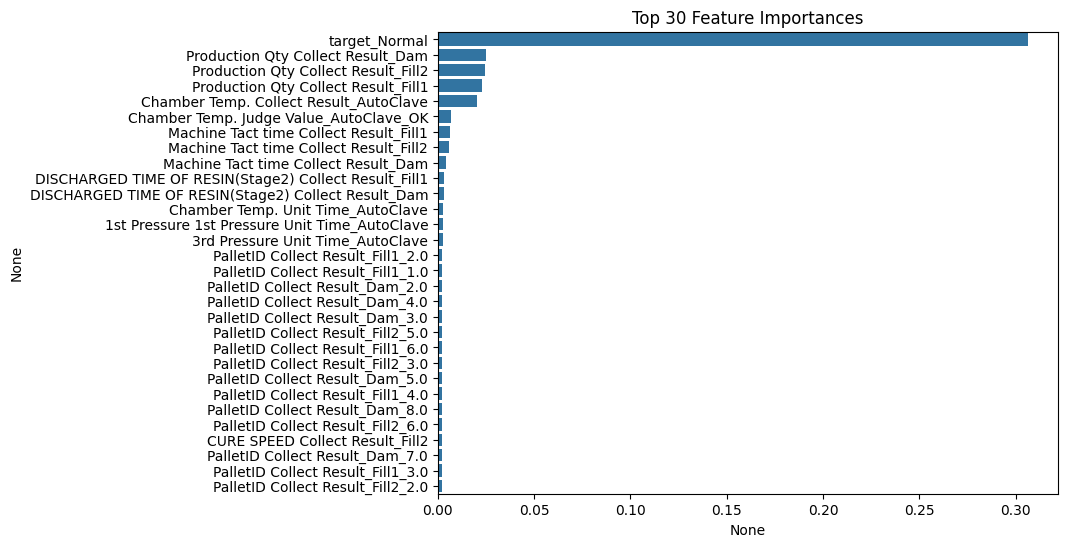

In [211]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = train_x.columns)
ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Top 30 Feature Importances')
sns.barplot(x=ftr_top30, y=ftr_top30.index)
plt.show()

In [209]:
from collections import Counter

# Counter를 사용하여 각 요소의 개수 계산
count = Counter(test_pred)

# 결과 출력
for element, frequency in count.items():
    print(f'Element: {element}, Count: {frequency}')

proba = model.predict_proba(df_test_x)
print(proba)

Element: 0, Count: 17335
Element: 1, Count: 26
[[0.8  0.2 ]
 [0.79 0.21]
 [0.79 0.21]
 ...
 [0.81 0.19]
 [0.72 0.28]
 [0.69 0.31]]


### 제출 파일 작성


In [171]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
